In [318]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from math import *
from copy import *
import copy
import pickle
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2019)
from langdetect import detect
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from pprint import pprint
import json
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import sklearn as sk
import spacy
from gensim.models import KeyedVectors
import cld2
from numpy import dot
from numpy.linalg import norm




[nltk_data] Downloading package wordnet to /Users/bennett/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [545]:
def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

def flatten_df(input_df, flatten_col):
    cols = list(input_df.columns)
    other_cols = [c for c in cols if not c == flatten_col]
    fc_flat = pd.DataFrame([[i,x] for i,y in input_df[flatten_col].apply(list).iteritems()
                            for x in y], columns=['I', flatten_col])
    fc_flat = fc_flat.set_index('I')
    output_df = input_df[other_cols].merge(fc_flat, left_index=True, right_index=True)
    return output_df

def get_topic_score(comment, model, n_topics, norm=True):
    """
    inputs: a bag-of-words representation of a comment (from a corpus)
    a gensim lda model
    a number of topics
    
    outputs: a normalized vector of size n_topics with the scores of each topic
    """
    model_output = np.array(model[comment])
    inds = model_output[:, 0].astype(int)
    scores = model_output[:, 1]
    out = np.zeros((n_topics))
    out[inds] = scores
    if norm:
        out = out / np.linalg.norm(out)
    return out.astype(float)

def cosine_similarity(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [314]:
def extract_topic_vectors(flat_pickle_name, 
                          tf_idf = True, n_topics = 20, npasses=5, **kwargs):
    
    """
    input: directory to a pickle, tf_idf bool, number of topics
    important kwargs: no_below (a number), no_above (between 0 and 1), keep_n (a number of words in the dictionary)
    output: an lda_model, topics, a corpus, a dictionary
    """
    
    file = open(flat_pickle_name, 'rb')
    preproc_df = pickle.load(file)
    file.close()
    print('Loaded File')
    
    corpus, dictionary = get_corpus(preproc_df, **kwargs)
    
    if tf_idf:
        tfidf = models.TfidfModel(corpus)
        corpus = tfidf[corpus]

    print('Made Corpus')
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=n_topics, id2word=dictionary, passes=npasses,
                                           workers=5)
    topics = lda_model.show_topics(num_topics=n_topics, num_words=10, log=False, formatted=True)

    return lda_model, topics, corpus, dictionary
    

In [315]:
def get_corpus(preproc_df, **kwargs):
    """
    input: a processed, flat df
    with a single row for every comment under column 'comments'
    outputs: corpus, a dict reporting how many words and how many times these words appear
    """

    processed_comments = preproc_df['comments'].map(preprocess)
    
    # Create a dictionary containing the number of times a word appears in the training set.
    dictionary = gensim.corpora.Dictionary(processed_comments)
    
    # Filter out tokens that appear in < than no_below documents (absolute number)
    # or > than no_above documents (fraction of total corpus size, not absolute number).
    # after the above two steps, keep only the first keep_n most frequent tokens.
    dictionary.filter_extremes(**kwargs)

    # Gensim doc2bow
    corpus = [dictionary.doc2bow(comment) for comment in processed_comments]
    return corpus, dictionary

In [98]:
# Tokenization: Split the text into sentences and the sentences into words. 
# Lowercase the words and remove punctuation.

# Words that have fewer than 3 characters are removed.

# Words are lemmatized — words in third person are changed to first person 
# and verbs in past and future tenses are changed into present.

# Words are stemmed — words are reduced to their root form.

# All stopwords are removed.


stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result



In [414]:
e

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101.])

In [422]:
listings[0].shape

(48864, 106)

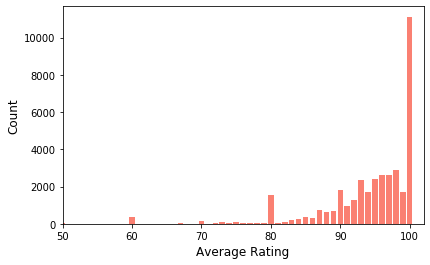

In [419]:
plt.figure(1, (6.47, 4))
b, e = np.histogram(listings[0].review_scores_rating, range=(0, 101), bins=101)
plt.bar(e[:-1], b, facecolor='salmon')
plt.xlim(50, 102)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [327]:

test = cld2.detect("Cómo estás mi amigo?")
test

Detections(is_reliable=True, bytes_found=23, details=(Detection(language_name='SPANISH', language_code='es', percent=95, score=1489.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0)))

In [334]:
test[2][0][1]

'es'

In [385]:
# data loading functions


# data cleaning functions


def clean_detect(x):
    try:
        #return detect(x)
        return cld2.detect(x).details[0][1]
    except:
        return 'No Language'
    
def name2HOST_NAME(x):
    if type(x['host_name']) is str:
        return x['comments'].replace(x['host_name'], 'HOST_NAME')
    else:
        return x['comments']

def preproc_df(df, pickle_name='', extract_host = False, change_name2HOST_NAME = False, 
               lang_condition = 'en', min_num_reviews = None):
    """
    input a df in the format of room_db
    with columns ['room_id', 'host_name', 'user_id', 'comments']
    with dtype int, str, list-of-int, list-of-str
    
    output flat_df with columns ['listing_id', 'host_name', 'user_id', 'comments', host_names_extracted, 'old_index']
    with dtype int, str, int, list-of-str, int
    
    if find_host, automatically find the name of the host(s) within a given listing
    fill a column with a list of these guesses.
    else, put an empty list
    
    args:
    lang_select selects the language of comments to condition on. 'en' for english. '' --> no filtering
    min_num_reviews: int. Filter out listings with less than min_num_reviews
    
    """
   
    lids = []
    hns = []
    uids = []
    flat_doc_comments = []
    host_names_extracted = []
    for index, row in df.head(n=df.shape[0]).iterrows():
        lid = row.room_id
        hn = row.host_name
        uid = row.user_id
        cs = row.comments
        lids.extend([lid]*len(cs))
        hns.extend([hn]*len(cs))
        uids.extend(uid)
        flat_doc_comments.extend(cs)
        #if extract_host:
        #    host_names_extracted.extend(extract_host_names(cs))
        #else:
        #    host_names_extracted.extend([[]*len(cs)])

    flat_df = pd.DataFrame({'listing_id':lids, 
                                'host_name': hns, 
                                'user_id':uids,
                                'comments':flat_doc_comments})
    
    flat_df.comments = flat_df.comments.fillna('')
    
    flat_df.host_name = flat_df.host_name.apply(lambda x: x.values[0])
    if change_name2HOST_NAME:
        flat_df['comments'] = flat_df.apply(lambda x: name2HOST_NAME(x), axis=1)

        #for ic, c in enumerate(flat_df.comments):
        #    name = flat_df.host_name.iloc[ic]
        #    if name is not np.nan:
        #        flat_df.comments.iloc[ic]=flat_df.comments.iloc[ic].replace(name, 'HOST_NAME')

    # ONLY LOOKS AT REVIEWS WITH 3+ CHARACTERS
    # ONLY LOOK AT REVIEWS IN ENGLISH
    flat_df = flat_df[flat_df.comments.apply(lambda x: len(x) >= 3)]
    if lang_condition:
        flat_df = flat_df[flat_df.comments.apply(lambda x: clean_detect(x) == lang_condition)]

    # REMOVE AUTOMATED MESSAGES
    flat_df = flat_df[flat_df.comments.apply(lambda x: x[:34] != 'The host canceled this reservation')]

    # REPLACE \n and \r with empty strings
    flat_df.comments = flat_df.comments.apply(lambda x: x.replace('\n', ' '))
    flat_df.comments = flat_df.comments.apply(lambda x: x.replace('\r', ' '))
    
    # remove reviews with < 10 words
    flat_df = flat_df[flat_df.comments.apply(lambda x: len(x.split(' ')) >= 10)]

    if pickle_name:
        with open(pickle_name, 'wb') as pickle_file:
            pickle.dump(flat_df, pickle_file)

    return flat_df

def load_room_db(listing_fnames, review_fnames, room_db_pickle_name='', load_from_pickle = False):
    
    listings = []
    reviews = []
    if load_from_pickle:        
        for fname in listing_fnames:
            file = open(fname, 'rb')
            object_file = pickle.load(file)
            listings.append(object_file)
            file.close()
        for fname in review_fnames:
            file = open(fname, 'rb')
            object_file = pickle.load(file)
            reviews.append(object_file)
            file.close()    
    else:
        for fname in listing_fnames:
            listings.append(pd.read_csv(fname, sep=','))
        for fname in review_fnames:
            reviews.append(pd.read_csv(fname, sep=','))
      
    # clean up column names
    l2d = {'id':'room_id', 
        'geolocation':'coordinates', 
        'neighbourhood_cleansed': 'neighborhood_clean',
       'price':'room_price',
       'last_review':'date_last_review'}
    for i, L in enumerate(listings):
        L = L.rename(columns={c:c.lower().replace(' ', '_') for c in L.columns})
        L = L.rename(columns=l2d)
        listings[i] = L
    for i, R in enumerate(reviews):
        R = R.rename(columns={c:c.lower().replace(' ', '_') for c in R.columns})
        reviews[i] = R
        
    reviews = reviews[0]  
    listing = listings[0]
    for c in sorted(reviews.columns):
        print(c)
    
    print('\n')
    for c in sorted(listing.columns):
        print(c)
        
    room_id_list = []
    for L in listings:
        room_id_list.extend(list(L.room_id))
    unique_room_id_list = sorted(np.unique(room_id_list))

    # build a DataFrame of room_id --> host_name, list of reviewers, list of comments
    # Takes some compute time (~10 minutes)
    
    hosts_for_room = [listing[listing.room_id == rid].host_name 
                      for rid in unique_room_id_list]
    print('Loaded Hosts')
    
    reviewers_for_room = {rid: list(reviews[reviews.listing_id == rid].reviewer_id) 
                          for rid in unique_room_id_list}
    print('Loaded Reviewer IDs')
    
    reviewer_names_for_room = {rid: list(reviews[reviews.listing_id == rid].reviewer_name) 
                               for rid in unique_room_id_list}
    print('Loaded Reviewer names')
    
    comments_for_room = {rid: list(reviews[reviews.listing_id == rid].comments) 
                         for rid in unique_room_id_list}
    print('Loaded Comments')
    room_db = pd.DataFrame({'room_id':unique_room_id_list,
                        'host_name':hosts_for_room,
                       'user_id':[reviewers_for_room[k] for k in unique_room_id_list],
                        'user_name': [reviewer_names_for_room[k] for k in unique_room_id_list],
                       'comments': [comments_for_room[k] for k in unique_room_id_list]})

    if room_db_pickle_name:
        with open(room_db_pickle_name, 'wb') as pickle_file:
            pickle.dump(room_db, pickle_file)
            
    return room_db, listings, reviews

In [344]:
room_db, listings, reviews = load_room_db(listing_fnames = ['/Users/bennett/Downloads/NYC data 0916/listings_gz.csv'],
                                          review_fnames= ['/Users/bennett/Downloads/NYC data 0916/reviews_gz.csv'],
                                          load_from_pickle=False)

/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


comments
date
id
listing_id
reviewer_id
reviewer_name


access
accommodates
amenities
availability_30
availability_365
availability_60
availability_90
bathrooms
bed_type
bedrooms
beds
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
calendar_last_scraped
calendar_updated
cancellation_policy
city
cleaning_fee
country
country_code
date_last_review
description
experiences_offered
extra_people
first_review
guests_included
has_availability
host_about
host_acceptance_rate
host_has_profile_pic
host_id
host_identity_verified
host_is_superhost
host_listings_count
host_location
host_name
host_neighbourhood
host_picture_url
host_response_rate
host_response_time
host_since
host_thumbnail_url
host_total_listings_count
host_url
host_verifications
house_rules
instant_bookable
interaction
is_business_travel_ready
is_location_exact
jurisdiction_names
last_scraped
latitude
license
listing_u

In [647]:
listings[0].columns

Index(['room_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [386]:
flat_df = preproc_df(room_db, change_name2HOST_NAME=True,)
pickle_name = '../../Desktop/Insight Project/airbnb/pickles/flat_df.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df, pickle_file)

In [387]:
flat_df.comments

2          I've stayed with my friend at the Midtown Cast...
3          We've been staying here for about 9 nights, en...
4          We had a wonderful stay at HOST_NAME's charmin...
5          Hi to everyone!  Would say our greatest compli...
6          HOST_NAME was very friendly and helpful, and h...
                                 ...                        
1143027    Great host. Very accommodating with our check ...
1143028    The place is much better in person. The space ...
1143029    HOST_NAME's place was really chill and was a g...
1143030    HOST_NAME's home was a lovely place to rest ou...
1143032    I really loved my stay in NYC at HOST_NAME's a...
Name: comments, Length: 889248, dtype: object

In [367]:
flat_df.comments[2]

"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.  Attention: it's on the 4th floor without a lift :-) but definetely worth it!"

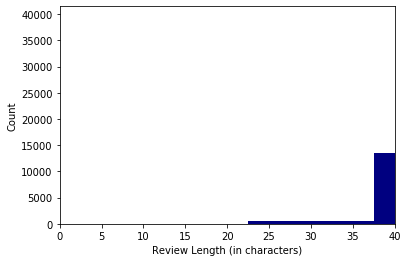

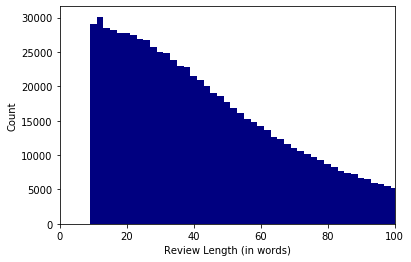

In [388]:

def center(L):
    return [np.mean([a, b]) for (a, b) in zip(L[:-1], L[0:])]

nb = 200
bw = 3000. / (1*nb)
b, e = np.histogram(list(flat_df.comments.apply(lambda x: len(x))), bins=nb, range=(0, 3000))
plt.bar(center(e), b, width=bw, lw=0, facecolor = 'navy')
plt.xlim(0, 40)
plt.xlabel('Review Length (in characters)')
plt.ylabel('Count')
plt.show()

nb = 250
bw = 500. / (1*nb)
b, e = np.histogram(list(flat_df.comments.apply(lambda x: len(x.split(' ')))), bins=nb, range = (0, 500))
plt.bar(center(e), b, width=bw, lw=0, facecolor = 'navy')
plt.xlim(0, 100)
plt.xlabel('Review Length (in words)')
plt.ylabel('Count')
plt.show()

In [389]:
'The host canceled my reservation'.lower()[:32] == 'the host canceled my reservation'

True

In [173]:
flat_df_newclean.user_id

0              9193
3            185050
4            456184
5            351855
6            363433
            ...    
325676    127641350
325678     43662901
325679     28703397
325680     25112195
325681     16637631
Name: user_id, Length: 265954, dtype: int64

In [390]:
fdf_listing_ids = np.unique(flat_df.listing_id)
fdf_user_ids = np.unique(flat_df.user_id)
fdf_listing_ids.shape

(36686,)

In [393]:
# get the number of reviews for every listing
# plot the distribution

n_revs_per_listing= np.zeros((len(fdf_listing_ids)))
n_revs_per_user= np.zeros((len(fdf_user_ids)))

print(flat_df.shape)
for ilist, lid in enumerate(fdf_listing_ids):
    n_revs_per_listing[ilist] = flat_df[flat_df.listing_id==lid].shape[0]
for iuid, uid in enumerate(fdf_user_ids):
    n_revs_per_user[iuid] = flat_df[flat_df.user_id == uid].shape[0]

(889248, 4)


In [197]:
n_revs_per_user.max()

41.0

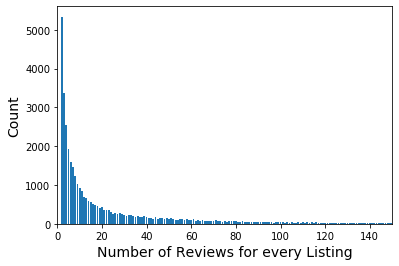

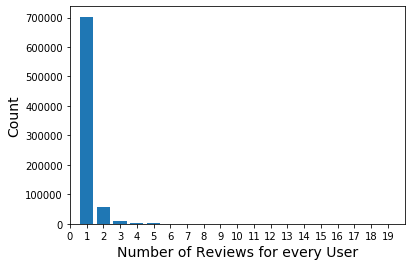

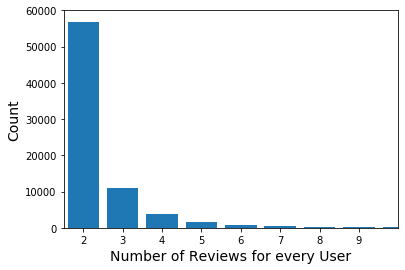

In [397]:
b_rpl, e_rpl = np.histogram(n_revs_per_listing, bins=360, range = (0, 360))
b_rpu, e_rpu = np.histogram(n_revs_per_user, bins = 50, range=(0, 50))
plt.bar(e_rpl[1:], b_rpl)
#plt.ylim((0, 1600))
plt.xlim((0, 150))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every Listing', fontsize = 14)
plt.show()

plt.bar(e_rpu[:-1], b_rpu)
plt.xlim(0, 20)
plt.ylim()
plt.xticks(range(20))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every User', fontsize = 14)
plt.show()

plt.bar(e_rpu[:-1], b_rpu)
plt.xlim(1.5, 10)
plt.ylim((0, 60000))
plt.xticks(range(2, 10))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every User', fontsize = 14)
plt.show()

In [398]:
print('Number of listings in NYC:', len(fdf_listing_ids))
print('Number of listings with at least 10 reviews:', len(n_revs_per_listing[n_revs_per_listing >= 10]))
print('\n')
print('mean reviews per listing:', n_revs_per_listing.mean())
print('stdev reviews per listing:', np.std(n_revs_per_listing)),
print('median reviews per listing:', np.median(n_revs_per_listing))


Number of listings in NYC: 36686
Number of listings with at least 10 reviews: 17285


mean reviews per listing: 24.23943738755929
stdev reviews per listing: 39.16429885080909
median reviews per listing: 8.0


In [400]:
len(flat_df)

889248

In [399]:

print('Number of reviewers who have more than 1 review:', len(n_revs_per_user[n_revs_per_user >= 2]))
print('Proportion of reviewers who have more than 1 review:', 
      round(len(n_revs_per_user[n_revs_per_user >= 2]) / len(n_revs_per_user), 5))


Number of reviewers who have more than 1 review: 75025
Proportion of reviewers who have more than 1 review: 0.09646


In [310]:
lda04, topics04, corpus04, dictionary04 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=4,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=4 topics')

lda07, topics07, corpus07, dictionary07 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=7 topics')

lda10, topics10, corpus10, dictionary10 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [314]:
[print(t, '\n') for t in topics04]
print('\n')
[print(t, '\n') for t in topics07]
print('\n')
[print(t, '\n') for t in topics10]

(0, '0.044*"place" + 0.032*"locat" + 0.031*"apart" + 0.030*"host" + 0.022*"recommend" + 0.020*"clean" + 0.019*"love" + 0.016*"comfort" + 0.016*"perfect" + 0.013*"amaz"') 

(1, '0.035*"room" + 0.031*"nice" + 0.023*"place" + 0.020*"good" + 0.018*"apart" + 0.017*"clean" + 0.017*"locat" + 0.013*"bathroom" + 0.011*"like" + 0.011*"night"') 

(2, '0.045*"apart" + 0.031*"locat" + 0.028*"subway" + 0.024*"walk" + 0.021*"place" + 0.020*"close" + 0.019*"restaur" + 0.017*"easi" + 0.016*"clean" + 0.015*"park"') 

(3, '0.033*"apart" + 0.028*"place" + 0.027*"check" + 0.024*"time" + 0.020*"locat" + 0.019*"clean" + 0.019*"host" + 0.014*"arriv" + 0.014*"help" + 0.013*"need"') 



(0, '0.025*"place" + 0.023*"room" + 0.021*"time" + 0.015*"host" + 0.015*"check" + 0.015*"arriv" + 0.014*"clean" + 0.013*"apart" + 0.013*"night" + 0.011*"leav"') 

(1, '0.037*"apart" + 0.030*"place" + 0.026*"locat" + 0.026*"check" + 0.022*"host" + 0.021*"recommend" + 0.020*"citi" + 0.019*"need" + 0.017*"perfect" + 0.016*"york"') 

[None, None, None, None, None, None, None, None, None, None]

In [315]:
lda04_tfidf, topics04_tfidf, corpus04_tfidf, dictionary04_tfidf =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=4,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=4 topics')

lda07_tfidf, topics07_tfidf, corpus07_tfidf, dictionary07_tfidf = \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=7,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=7 topics')

lda10_tfidf, topics10_tfidf, corpus10_tfidf, dictionary10_tfidf = \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=10,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=10 topics')

Loaded File
Made Corpus
finished tf-idf lda model, n=4 topics
Loaded File
Made Corpus
finished tf-idf lda model, n=7 topics
Loaded File
Made Corpus
finished tf-idf lda model, n=10 topics


In [316]:
[print(t, '\n') for t in topics04_tfidf]
print('\n')
[print(t, '\n') for t in topics07_tfidf]
print('\n')
[print(t, '\n') for t in topics10_tfidf]

(0, '0.016*"place" + 0.015*"nice" + 0.015*"host" + 0.012*"help" + 0.012*"recommend" + 0.012*"clean" + 0.011*"thank" + 0.011*"friend" + 0.011*"time" + 0.011*"apart"') 

(1, '0.013*"place" + 0.011*"locat" + 0.011*"apart" + 0.011*"perfect" + 0.010*"love" + 0.010*"host" + 0.009*"super" + 0.009*"recommend" + 0.009*"clean" + 0.009*"amaz"') 

(2, '0.017*"check" + 0.012*"quick" + 0.012*"easi" + 0.011*"apart" + 0.011*"question" + 0.010*"respond" + 0.010*"communic" + 0.010*"place" + 0.009*"arriv" + 0.008*"locat"') 

(3, '0.010*"room" + 0.008*"good" + 0.008*"apart" + 0.007*"night" + 0.007*"bathroom" + 0.007*"nice" + 0.007*"place" + 0.006*"sleep" + 0.006*"bedroom" + 0.006*"small"') 



(0, '0.011*"room" + 0.009*"good" + 0.008*"night" + 0.008*"apart" + 0.008*"bathroom" + 0.007*"place" + 0.007*"sleep" + 0.007*"nice" + 0.007*"nois" + 0.006*"clean"') 

(1, '0.021*"close" + 0.019*"nice" + 0.017*"place" + 0.015*"good" + 0.015*"central" + 0.015*"subway" + 0.015*"clean" + 0.014*"locat" + 0.014*"host" + 0.

[None, None, None, None, None, None, None, None, None, None]

In [1007]:
flat_df_newclean_HOST_NAME.topic_scores.iloc[0]

array([0.32516765, 0.        , 0.        , 0.        , 0.94565639,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [321]:
lda04_permissive, topics04_permissive, corpus04_permissive, dictionary04_permissive =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = Falase, n_topics=4,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=4 topics')

lda07_permissive, topics07_permissive, corpus07_permissive, dictionary07_permissive = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=7 topics')

lda10_permissive, topics10_permissive, corpus10_permissive, dictionary10_permissive = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [322]:
[print(t, '\n') for t in topics04_permissive]
print('\n')
[print(t, '\n') for t in topics07_permissive]
print('\n')
[print(t, '\n') for t in topics10_permissive]

(0, '0.023*"apart" + 0.014*"room" + 0.014*"place" + 0.014*"stay" + 0.012*"great" + 0.011*"locat" + 0.010*"clean" + 0.010*"night" + 0.009*"good" + 0.007*"nice"') 

(1, '0.027*"apart" + 0.022*"walk" + 0.018*"park" + 0.018*"locat" + 0.016*"central" + 0.015*"subway" + 0.014*"stay" + 0.013*"time" + 0.012*"great" + 0.010*"minut"') 

(2, '0.055*"great" + 0.042*"stay" + 0.038*"apart" + 0.034*"locat" + 0.032*"place" + 0.025*"host" + 0.020*"clean" + 0.017*"recommend" + 0.015*"perfect" + 0.013*"easi"') 

(3, '0.036*"place" + 0.034*"stay" + 0.027*"nice" + 0.019*"great" + 0.018*"room" + 0.018*"clean" + 0.017*"host" + 0.016*"subway" + 0.015*"locat" + 0.015*"recommend"') 



(0, '0.035*"room" + 0.029*"stay" + 0.023*"place" + 0.019*"nice" + 0.018*"great" + 0.014*"like" + 0.014*"good" + 0.012*"host" + 0.010*"comfort" + 0.010*"clean"') 

(1, '0.030*"apart" + 0.017*"stay" + 0.016*"place" + 0.016*"great" + 0.015*"arriv" + 0.012*"clean" + 0.012*"leav" + 0.011*"host" + 0.011*"time" + 0.010*"need"') 

(2, '0

[None, None, None, None, None, None, None, None, None, None]

In [324]:
lda04_permissive_tfidf, topics04_permissive_tfidf, corpus04_permissive_tfidf, dictionary04_permissive_tfidf =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=4,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=4 topics')

lda07_permissive_tfidf, topics07_permissive_tfidf, corpus07_permissive_tfidf, dictionary07_permissive_tfidf = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=7,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=7 topics')

lda10_permissive_tfidf, topics10_permissive_tfidf, corpus10_permissive_tfidf, dictionary10_permissive_tfidf = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=10,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [325]:
[print(t, '\n') for t in topics04_permissive_tfidf]
print('\n')
[print(t, '\n') for t in topics07_permissive_tfidf]
print('\n')
[print(t, '\n') for t in topics10_permissive_tfidf]

(0, '0.006*"place" + 0.006*"great" + 0.006*"apart" + 0.005*"stay" + 0.005*"nice" + 0.005*"room" + 0.005*"host" + 0.005*"time" + 0.005*"clean" + 0.004*"help"') 

(1, '0.013*"great" + 0.012*"place" + 0.010*"host" + 0.010*"stay" + 0.010*"nice" + 0.010*"locat" + 0.010*"clean" + 0.009*"apart" + 0.009*"recommend" + 0.008*"definit"') 

(2, '0.007*"great" + 0.006*"place" + 0.006*"apart" + 0.006*"walk" + 0.005*"stay" + 0.005*"locat" + 0.005*"close" + 0.005*"restaur" + 0.005*"perfect" + 0.005*"nice"') 

(3, '0.006*"room" + 0.005*"apart" + 0.005*"place" + 0.005*"good" + 0.005*"great" + 0.005*"nice" + 0.005*"clean" + 0.004*"stay" + 0.004*"locat" + 0.004*"night"') 



(0, '0.007*"place" + 0.007*"great" + 0.006*"apart" + 0.006*"stay" + 0.005*"host" + 0.005*"locat" + 0.005*"nice" + 0.005*"michael" + 0.005*"clean" + 0.005*"recommend"') 

(1, '0.012*"great" + 0.011*"place" + 0.010*"locat" + 0.010*"nice" + 0.009*"close" + 0.009*"stay" + 0.009*"apart" + 0.008*"perfect" + 0.008*"clean" + 0.008*"host"') 



[None, None, None, None, None, None, None, None, None, None]

In [330]:
lda04_strict_top, topics04_strict_top, corpus04_strict_top, dictionary04_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=4,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=4 topics')

lda07_strict_top, topics07_strict_top, corpus07_strict_top, dictionary07_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=7 topics')

lda10_strict_top, topics10_strict_top, corpus10_strict_top, dictionary10_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=10 topics')

lda15_strict_top, topics15_strict_top, corpus15_strict_top, dictionary15_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=15,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=15 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics
Loaded File
Made Corpus
finished lda model, n=15 topics


In [331]:
[print(t, '\n') for t in topics04_strict_top]
print('\n')
[print(t, '\n') for t in topics07_strict_top]
print('\n')
[print(t, '\n') for t in topics10_strict_top]
print('\n')
[print(t, '\n') for t in topics15_strict_top]

(0, '0.014*"wonder" + 0.012*"feel" + 0.011*"visit" + 0.011*"amaz" + 0.010*"enjoy" + 0.010*"come" + 0.009*"felt" + 0.009*"hous" + 0.009*"give" + 0.009*"look"') 

(1, '0.014*"super" + 0.009*"accommod" + 0.009*"bathroom" + 0.009*"amaz" + 0.008*"space" + 0.007*"villag" + 0.006*"towel" + 0.006*"best" + 0.006*"east" + 0.005*"bedroom"') 

(2, '0.014*"station" + 0.012*"minut" + 0.010*"squar" + 0.010*"flat" + 0.009*"kitchen" + 0.009*"small" + 0.009*"near" + 0.008*"question" + 0.008*"littl" + 0.008*"park"') 

(3, '0.014*"street" + 0.012*"park" + 0.009*"block" + 0.008*"away" + 0.008*"nois" + 0.007*"shop" + 0.007*"sleep" + 0.007*"right" + 0.005*"littl" + 0.005*"food"') 



(0, '0.015*"station" + 0.015*"quick" + 0.014*"flat" + 0.013*"minut" + 0.013*"question" + 0.012*"leav" + 0.010*"key" + 0.009*"respond" + 0.009*"answer" + 0.008*"late"') 

(1, '0.021*"park" + 0.016*"squar" + 0.016*"shop" + 0.014*"distanc" + 0.012*"away" + 0.012*"block" + 0.011*"bar" + 0.010*"right" + 0.010*"minut" + 0.010*"street"

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [348]:
lda10_strict_top_05, topics10_strict_top_05, corpus10_strict_top_05, dictionary10_strict_top_05 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_strict_top_05]


lda10_st_05_sb0200, topics10_st_05_sb0200, corpus10_st_05_sb0200, dictionary10_st_05_sb0200 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 200, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_st_05_sb0200]


lda07_st_05_sb1000, topics07_st_05_sb1000, corpus07_st_05_sb1000, dictionary07_st_05_sb1000 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 1000, no_above = .05,
                                                     npasses= 10)


Loaded File
Made Corpus
finished lda model, n=10 topics
(0, '0.025*"coffe" + 0.020*"towel" + 0.013*"breakfast" + 0.012*"food" + 0.009*"water" + 0.009*"plenti" + 0.009*"fresh" + 0.009*"store" + 0.008*"fridg" + 0.008*"morn"') 

(1, '0.076*"awesom" + 0.024*"john" + 0.023*"cute" + 0.016*"sweet" + 0.013*"jam" + 0.013*"roommat" + 0.011*"paul" + 0.010*"cool" + 0.010*"ador" + 0.010*"comfi"') 

(2, '0.039*"east" + 0.038*"villag" + 0.019*"west" + 0.016*"soho" + 0.014*"spot" + 0.014*"heart" + 0.013*"upper" + 0.012*"lower" + 0.012*"loft" + 0.012*"explor"') 

(3, '0.039*"view" + 0.038*"better" + 0.021*"couldn" + 0.017*"absolut" + 0.015*"incred" + 0.010*"awesom" + 0.010*"hotel" + 0.009*"extrem" + 0.008*"state" + 0.008*"decor"') 

(4, '0.031*"flat" + 0.027*"transport" + 0.023*"lot" + 0.020*"nearbi" + 0.018*"public" + 0.017*"store" + 0.015*"famili" + 0.015*"plenti" + 0.014*"equip" + 0.013*"groceri"') 

(5, '0.015*"nois" + 0.011*"shower" + 0.011*"door" + 0.011*"floor" + 0.010*"issu" + 0.010*"window" + 

NameError: name 'topics10_st_05_sb1000' is not defined

In [349]:
print('finished lda model, n=7 topics')
[print(t, '\n') for t in topics07_st_05_sb1000]



finished lda model, n=7 topics
(0, '0.035*"respond" + 0.032*"late" + 0.031*"flexibl" + 0.024*"answer" + 0.022*"key" + 0.021*"meet" + 0.017*"earli" + 0.017*"prompt" + 0.016*"flight" + 0.016*"avail"') 

(1, '0.053*"hous" + 0.047*"flat" + 0.038*"metro" + 0.033*"appart" + 0.027*"day" + 0.020*"neighbourhood" + 0.018*"spend" + 0.017*"cosi" + 0.017*"harlem" + 0.016*"warm"') 

(2, '0.022*"food" + 0.019*"train" + 0.018*"lot" + 0.016*"local" + 0.016*"nearbi" + 0.016*"explor" + 0.015*"line" + 0.015*"short" + 0.014*"coffe" + 0.012*"privat"') 

(3, '0.032*"nois" + 0.031*"floor" + 0.025*"price" + 0.023*"transport" + 0.022*"pretti" + 0.019*"valu" + 0.019*"window" + 0.019*"stair" + 0.018*"public" + 0.018*"noisi"') 

(4, '0.023*"guest" + 0.019*"know" + 0.017*"list" + 0.016*"door" + 0.016*"issu" + 0.014*"book" + 0.014*"accur" + 0.014*"think" + 0.013*"wasn" + 0.013*"say"') 

(5, '0.035*"towel" + 0.030*"bed" + 0.023*"water" + 0.022*"shower" + 0.018*"plenti" + 0.017*"wifi" + 0.017*"larg" + 0.015*"equip" + 

[None, None, None, None, None, None, None]

In [424]:

lda10_st_05_sb1000_NEW, topics10_st_05_sb1000_NEW, corpus10_st_05_sb1000_NEW, dictionary10_st_05_sb1000_NEW =  \
        extract_topic_vectors('../../Desktop/Insight Project/airbnb/pickles/flat_df.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 1000, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_st_05_sb1000_NEW]

Loaded File
Made Corpus
finished lda model, n=10 topics
(0, '0.053*"awesom" + 0.049*"bar" + 0.044*"stylish" + 0.041*"lot" + 0.039*"view" + 0.039*"spot" + 0.038*"cool" + 0.028*"comfi" + 0.026*"williamsburg" + 0.025*"local"') 

(1, '0.028*"bedroom" + 0.024*"sleep" + 0.019*"shower" + 0.017*"towel" + 0.017*"nois" + 0.017*"door" + 0.015*"work" + 0.013*"small" + 0.013*"floor" + 0.012*"window"') 

(2, '0.028*"person" + 0.019*"sweet" + 0.018*"warm" + 0.017*"spend" + 0.017*"care" + 0.015*"famili" + 0.015*"meet" + 0.015*"week" + 0.014*"know" + 0.014*"hope"') 

(3, '0.074*"respond" + 0.046*"pictur" + 0.033*"exact" + 0.030*"answer" + 0.028*"messag" + 0.023*"sure" + 0.022*"book" + 0.021*"avail" + 0.020*"better" + 0.019*"fast"') 

(4, '0.047*"food" + 0.045*"store" + 0.042*"coffe" + 0.039*"transport" + 0.028*"famili" + 0.027*"public" + 0.027*"groceri" + 0.025*"nearbi" + 0.023*"breakfast" + 0.022*"plenti"') 

(5, '0.037*"price" + 0.024*"expect" + 0.018*"guest" + 0.016*"overal" + 0.016*"issu" + 0.014*"

[None, None, None, None, None, None, None, None, None, None]

In [376]:
topics10_st_05_sb1000

[(0,
  '0.051*"absolut" + 0.036*"incred" + 0.030*"studio" + 0.029*"hope" + 0.026*"decor" + 0.020*"return" + 0.018*"soon" + 0.017*"futur" + 0.015*"charm" + 0.015*"truli"'),
 (1,
  '0.103*"hous" + 0.097*"awesom" + 0.091*"better" + 0.058*"appart" + 0.053*"price" + 0.046*"couldn" + 0.046*"valu" + 0.026*"hotel" + 0.023*"david" + 0.022*"ask"'),
 (2,
  '0.037*"flexibl" + 0.034*"late" + 0.029*"meet" + 0.029*"key" + 0.028*"respond" + 0.021*"list" + 0.020*"answer" + 0.020*"earli" + 0.020*"accur" + 0.019*"flight"'),
 (3,
  '0.064*"east" + 0.062*"villag" + 0.038*"lot" + 0.033*"explor" + 0.032*"spot" + 0.031*"west" + 0.029*"heart" + 0.029*"cool" + 0.025*"soho" + 0.022*"upper"'),
 (4,
  '0.028*"towel" + 0.028*"coffe" + 0.022*"breakfast" + 0.022*"take" + 0.016*"care" + 0.015*"offer" + 0.015*"food" + 0.015*"morn" + 0.014*"inform" + 0.014*"know"'),
 (5,
  '0.065*"view" + 0.038*"privat" + 0.027*"share" + 0.026*"attract" + 0.025*"privaci" + 0.018*"guest" + 0.018*"roommat" + 0.018*"hospit" + 0.017*"warm" 

In [425]:
topics10_st_05_sb1000_df = pd.DataFrame()
w_df = np.zeros((10, 10))
st_df = np.zeros((10, 10), dtype=str)

for ind, vals in topics10_st_05_sb1000:
    w_label = 'topic_weight_'+ str(ind)
    s_label = 'topic_stem_'+ str(ind)
    weights_x_stems = vals.split(' + ')
    weights = [float(i.split('*')[0]) for i in weights_x_stems]
    stems = [i.split('*')[1][1:-1] for i in weights_x_stems]
    topics10_st_05_sb1000_df[w_label] = weights
    topics10_st_05_sb1000_df[s_label] = stems



In [487]:
topics10_st_05_sb1000_NEW_df = pd.DataFrame()
w_df = np.zeros((10, 10))
st_df = np.zeros((10, 10), dtype=str)

for ind, vals in topics10_st_05_sb1000_NEW:
    w_label = 'topic_weight_'+ str(ind)
    s_label = 'topic_stem_'+ str(ind)
    weights_x_stems = vals.split(' + ')
    weights = [float(i.split('*')[0]) for i in weights_x_stems]
    stems = [i.split('*')[1][1:-1] for i in weights_x_stems]
    topics10_st_05_sb1000_NEW_df[w_label] = weights
    topics10_st_05_sb1000_NEW_df[s_label] = stems

w_cols = ['topic_weight_'+str(i) for i in range(10)]
s_cols = ['topic_stem_'+str(i) for i in range(10)]
print(w_cols)
print(s_cols)
topics10_st_05_sb1000_NEW_df[s_cols]

['topic_weight_0', 'topic_weight_1', 'topic_weight_2', 'topic_weight_3', 'topic_weight_4', 'topic_weight_5', 'topic_weight_6', 'topic_weight_7', 'topic_weight_8', 'topic_weight_9']
['topic_stem_0', 'topic_stem_1', 'topic_stem_2', 'topic_stem_3', 'topic_stem_4', 'topic_stem_5', 'topic_stem_6', 'topic_stem_7', 'topic_stem_8', 'topic_stem_9']


,topic_stem_0,topic_stem_1,topic_stem_2,topic_stem_3,topic_stem_4,topic_stem_5,topic_stem_6,topic_stem_7,topic_stem_8,topic_stem_9
0,awesom,bedroom,person,respond,food,price,metro,late,explor,hospit
1,bar,sleep,sweet,pictur,store,expect,line,squar,cute,decor
2,stylish,shower,warm,exact,coffe,guest,flat,central,travel,extrem
3,lot,towel,spend,answer,transport,overal,equip,airport,describ,thought
4,view,nois,care,messag,famili,issu,studio,flight,east,amen
5,spot,door,famili,sure,public,valu,min,earli,exact,privat
6,cool,work,meet,book,groceri,hotel,neighbourhood,flexibl,weekend,touch
7,comfi,small,week,avail,nearbi,thing,stop,valu,villag,absolut
8,williamsburg,floor,know,better,breakfast,stair,downtown,appart,spot,attent
9,local,window,hope,fast,plenti,think,take,hour,short,incred


['topic_weight_0', 'topic_weight_1', 'topic_weight_2', 'topic_weight_3', 'topic_weight_4', 'topic_weight_5', 'topic_weight_6', 'topic_weight_7', 'topic_weight_8', 'topic_weight_9']
['topic_stem_0', 'topic_stem_1', 'topic_stem_2', 'topic_stem_3', 'topic_stem_4', 'topic_stem_5', 'topic_stem_6', 'topic_stem_7', 'topic_stem_8', 'topic_stem_9']


,topic_stem_0,topic_stem_1,topic_stem_2,topic_stem_3,topic_stem_4,topic_stem_5,topic_stem_6,topic_stem_7,topic_stem_8,topic_stem_9
0,awesom,bedroom,person,respond,food,price,metro,late,explor,hospit
1,bar,sleep,sweet,pictur,store,expect,line,squar,cute,decor
2,stylish,shower,warm,exact,coffe,guest,flat,central,travel,extrem
3,lot,towel,spend,answer,transport,overal,equip,airport,describ,thought
4,view,nois,care,messag,famili,issu,studio,flight,east,amen
5,spot,door,famili,sure,public,valu,min,earli,exact,privat
6,cool,work,meet,book,groceri,hotel,neighbourhood,flexibl,weekend,touch
7,comfi,small,week,avail,nearbi,thing,stop,valu,villag,absolut
8,williamsburg,floor,know,better,breakfast,stair,downtown,appart,spot,attent
9,local,window,hope,fast,plenti,think,take,hour,short,incred


In [ ]:
topic10 = pd.DataFrame('topic_stems_10': )

In [340]:
len(dictionary10.items())

773

In [333]:
[print(t, '\n') for t in topics10_strict_top_05]

(0, '0.017*"awesom" + 0.015*"absolut" + 0.013*"incred" + 0.011*"extrem" + 0.010*"michael" + 0.009*"comfi" + 0.008*"hospit" + 0.008*"better" + 0.007*"warm" + 0.007*"make"') 

(1, '0.034*"flat" + 0.025*"hous" + 0.016*"metro" + 0.015*"harlem" + 0.010*"neighbourhood" + 0.009*"line" + 0.008*"equip" + 0.008*"downtown" + 0.008*"train" + 0.007*"appart"') 

(2, '0.012*"nois" + 0.012*"floor" + 0.011*"issu" + 0.009*"door" + 0.009*"shower" + 0.008*"window" + 0.007*"problem" + 0.007*"wasn" + 0.007*"light" + 0.006*"noisi"') 

(3, '0.011*"train" + 0.010*"famili" + 0.010*"short" + 0.009*"store" + 0.008*"plenti" + 0.008*"late" + 0.007*"line" + 0.007*"group" + 0.007*"abl" + 0.006*"earli"') 

(4, '0.013*"late" + 0.013*"key" + 0.011*"problem" + 0.011*"alex" + 0.010*"instruct" + 0.009*"flight" + 0.008*"clear" + 0.008*"list" + 0.008*"contact" + 0.008*"answer"') 

(5, '0.022*"villag" + 0.016*"east" + 0.010*"west" + 0.010*"lot" + 0.009*"coffe" + 0.009*"spot" + 0.009*"heart" + 0.008*"chelsea" + 0.008*"david" +

[None, None, None, None, None, None, None, None, None, None]

In [485]:
lda08_st10_sb1000, topics08_st10_sb1000, corpus08_st10_sb1000, dictionary08_st10_sb1000 =  \
        extract_topic_vectors('../../Desktop/Insight Project/airbnb/pickles/flat_df.pkl',
                                                             tf_idf = False, n_topics=8,
                                                              no_below = 1000, no_above = .1,
                                                     npasses= 10)




Loaded File
Made Corpus
(0, '0.055*"look" + 0.038*"valu" + 0.037*"exact" + 0.032*"pictur" + 0.031*"expect" + 0.030*"better" + 0.027*"price" + 0.027*"transport" + 0.026*"describ" + 0.021*"public"') 

(1, '0.060*"station" + 0.055*"minut" + 0.044*"train" + 0.036*"away" + 0.025*"metro" + 0.024*"near" + 0.020*"conveni" + 0.020*"squar" + 0.018*"block" + 0.017*"line"') 

(2, '0.025*"night" + 0.017*"sleep" + 0.012*"littl" + 0.012*"door" + 0.012*"nois" + 0.011*"issu" + 0.011*"thing" + 0.010*"peopl" + 0.010*"floor" + 0.010*"airbnb"') 

(3, '0.064*"park" + 0.034*"shop" + 0.031*"central" + 0.027*"food" + 0.026*"street" + 0.022*"coffe" + 0.020*"block" + 0.020*"store" + 0.019*"nearbi" + 0.018*"lot"') 

(4, '0.040*"beauti" + 0.036*"amaz" + 0.023*"decor" + 0.022*"brooklyn" + 0.022*"stylish" + 0.020*"view" + 0.017*"wonder" + 0.016*"spacious" + 0.015*"spot" + 0.015*"cool"') 

(5, '0.030*"welcom" + 0.023*"feel" + 0.022*"hous" + 0.021*"experi" + 0.021*"amaz" + 0.020*"come" + 0.019*"kind" + 0.018*"york" + 

[None, None, None, None, None, None, None, None]

In [612]:
pwd

'/Users/bennett/Documents/GitHub'

In [613]:
pickle_name

'../Flask/Airbnb/MVP/lda08_st10_sb1000_dict_NEW.pkl'

In [616]:
pf

'../Flask/Airbnb/MVP/csrdb.pkl'

In [615]:
lda08_st10_sb1000_dict = {}
lda08_st10_sb1000_dict['model'] = lda08_st10_sb1000
lda08_st10_sb1000_dict['corpus'] = corpus08_st10_sb1000
lda08_st10_sb1000_dict['topics'] =  topics08_st10_sb1000
lda08_st10_sb1000_dict['dictionary'] = dictionary08_st10_sb1000


print(len(topics08_st10_sb1000))
print(np.shape(clean_scored_room_db.mean_topic_score.iloc[0]))
print(np.shape(clean_scored_room_db.topic_scores.iloc[0][0]))


pf = '../Flask/Airbnb/MVP/csrdb.pkl'
print('\n', pf)
with open(pf, 'wb') as pickle_file:
        pickle.dump(clean_scored_room_db, pickle_file)

pickle_name = '../Flask/Airbnb/MVP/lda08_st10_sb1000_dict_NEW.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(lda08_st10_sb1000_dict, pickle_file)

8
(8,)
(8,)

 ../../Desktop/Flask/Airbnb/MVP/csrdb.pkl
../Flask/Airbnb/MVP/lda08_st10_sb1000_dict_NEW.pkl


In [608]:
clean_scored_room_db.mean_topic_score.iloc[0]

array([0.08566015, 0.22303034, 0.29497779, 0.06787513, 0.36609403,
       0.25946266, 0.0465094 , 0.22226811])

In [600]:
len(lda08_st10_sb1000_dict['topics'])

8

In [489]:
topics08_st10_sb1000_NEW_df = pd.DataFrame()
w_df = np.zeros((10, 8))
st_df = np.zeros((10, 8), dtype=str)

for ind, vals in topics08_st10_sb1000:
    w_label = 'topic_weight_'+ str(ind)
    s_label = 'topic_stem_'+ str(ind)
    weights_x_stems = vals.split(' + ')
    weights = [float(i.split('*')[0]) for i in weights_x_stems]
    stems = [i.split('*')[1][1:-1] for i in weights_x_stems]
    topics08_st10_sb1000_NEW_df[w_label] = weights
    topics08_st10_sb1000_NEW_df[s_label] = stems

w_cols = ['topic_weight_'+str(i) for i in range(8)]
s_cols = ['topic_stem_'+str(i) for i in range(8)]
print(w_cols)
print(s_cols)
topics08_st10_sb1000_NEW_df[s_cols]

['topic_weight_0', 'topic_weight_1', 'topic_weight_2', 'topic_weight_3', 'topic_weight_4', 'topic_weight_5', 'topic_weight_6', 'topic_weight_7']
['topic_stem_0', 'topic_stem_1', 'topic_stem_2', 'topic_stem_3', 'topic_stem_4', 'topic_stem_5', 'topic_stem_6', 'topic_stem_7']


,topic_stem_0,topic_stem_1,topic_stem_2,topic_stem_3,topic_stem_4,topic_stem_5,topic_stem_6,topic_stem_7
0,look,station,night,park,beauti,welcom,kitchen,quick
1,valu,minut,sleep,shop,amaz,feel,bathroom,respond
2,exact,train,littl,central,decor,hous,bedroom,question
3,pictur,away,door,food,brooklyn,experi,bed,respons
4,expect,metro,nois,street,stylish,amaz,privat,accommod
5,better,near,issu,coffe,view,come,towel,arriv
6,price,conveni,thing,block,wonder,kind,small,answer
7,transport,squar,peopl,store,spacious,york,larg,messag
8,describ,block,floor,nearbi,spot,best,live,late
9,public,line,airbnb,lot,cool,visit,shower,flexibl


In [492]:
topics08_st10_sb1000_NEW_df.topic_stem_1.values

array(['station', 'minut', 'train', 'away', 'metro', 'near', 'conveni',
       'squar', 'block', 'line'], dtype=object)

In [493]:
topics08_st10_sb1000_NEW_df.topic_stem_2.values

array(['night', 'sleep', 'littl', 'door', 'nois', 'issu', 'thing',
       'peopl', 'floor', 'airbnb'], dtype=object)

In [ ]:
[print(t, '\n') for t in topics10_strict_top_05]

In [432]:
len(n_revs_per_listing)

36686

In [398]:
fname = datadir + 'flat_df_newclean_HOST_NAME.pkl'
file = open(fname, 'rb')
flat_df_newclean_HOST_NAME = pickle.load(file)
file.close()


In [399]:
flat_df_newclean_HOST_NAME.shape

(265954, 4)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 265954 but corresponding boolean dimension is 14447

In [451]:
fdf_listing_ids.shape

(14447,)

array([0.25745745, 0.2696681 , 0.07539007, 0.40575163, 0.40456645,
       0.22725742, 0.29718346, 0.02827635, 0.35165703, 0.51242225])

In [1123]:
np.random.permutation([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]])

array([[ 3,  4,  5],
       [ 6,  7,  8],
       [ 0,  1,  2],
       [ 9, 10, 11]])

In [522]:
len(corpus08_st10_sb1000)

889248

0


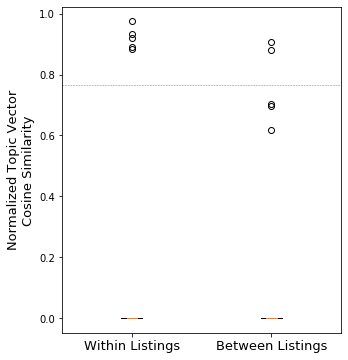

In [515]:
fdf_listing_ids_ge20 = fdf_listing_ids[n_revs_per_listing >= 20]
random_lids = np.random.permutation(fdf_listing_ids_ge20)
sims_within = np.zeros((len(fdf_listing_ids_ge20)))
sims_between = np.zeros((len(fdf_listing_ids_ge20)))
sims_random =  np.zeros((len(fdf_listing_ids_ge20)))
n_topics = 10
model = lda10_st_05_sb1000_NEW
norm=True
consistent_lengths = True

flat_df['corpus10_st_05_sb1000_NEW'] = corpus10_st_05_sb1000_NEW
for i, lid in enumerate(fdf_listing_ids_ge20[:5]):
    if not i % 500:
        print(i)
    #get comments in bag-of-words format
    comments = list(flat_df[flat_df.listing_id == lid].corpus10_st_05_sb1000_NEW)
    
    comms_a = comments[::2]
    comms_b = comments[1::2]
    topic_scores_a = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_a])
    topic_scores_b = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_b])
    
    random_lid = random_lids[i]
    random_comments = \
        list(flat_df[flat_df.listing_id == random_lid].corpus10_st_05_sb1000_NEW)
    random_comms = random_comments[::2]
    random_topic_scores = np.array([get_topic_score(c, model, n_topics, norm) for c in random_comms])
    
    if consistent_lengths:
        minlen = np.min([len(i) for i in [topic_scores_a, topic_scores_b, random_topic_scores]])
        topic_scores_a = np.random.permutation(topic_scores_a)[:minlen]
        topic_scores_b = np.random.permutation(topic_scores_b)[:minlen]
        random_topic_scores = np.random.permutation(random_topic_scores)[:minlen]
    
    
    mean_topic_score_a = np.mean(topic_scores_a, axis=0)
    mean_topic_score_b = np.mean(topic_scores_b, axis=0)
    random_mean_topic_score = np.mean(random_topic_scores, axis=0)
    
    
    r = np.random.uniform(low=0, high=1.0, size=10)
    r_norm = r/ np.linalg.norm(r)
    
    sims_within[i] = cosine_similarity(mean_topic_score_a, mean_topic_score_b)
    sims_between[i] = cosine_similarity(mean_topic_score_a, random_mean_topic_score) 
    sims_random[i] = cosine_similarity(mean_topic_score_a, r_norm)
    
plt.figure(1, (5, 6))
plt.boxplot([sims_within, sims_between], notch = True)
plt.gca().set_xticklabels(['Within Listings', 'Between Listings'], fontsize=13)
plt.ylabel('Normalized Topic Vector\nCosine Similarity', fontsize=13)
plt.gca().axhline(0.7670089074038959, ls='--', lw=0.5, alpha=0.5, c='k')

In [495]:
len(topics08_st10_sb1000)

8

In [507]:
fdf_listing_ids

array([    2595,     3831,     5022, ..., 37400410, 37416939, 37447887])

In [511]:
fdf_listing_ids[n_revs_per_listing >= 20]

array([    2595,     3831,     5099, ..., 34278936, 34302570, 35055076])

In [528]:
def evaluate_topics(fdf, lda_dict, n_revs_per_listing, min_revs, corpus_key_name,
                    norm=True, consistent_lengths = True):
    
    fdf_listing_ids = np.unique(fdf.listing_id)
    fdf_listing_ids_ge20 = fdf_listing_ids[n_revs_per_listing >= min_revs]
    
    model = lda_dict['model']
    topics = lda_dict['topics']
    dictionary = lda_dict['dictionary']
    corpus = lda_dict['corpus']
    
    random_lids = np.random.permutation(fdf_listing_ids_ge20)
    sims_within = np.zeros((len(fdf_listing_ids_ge20)))
    sims_between = np.zeros((len(fdf_listing_ids_ge20)))
    sims_random =  np.zeros((len(fdf_listing_ids_ge20)))
    n_topics = len(topics)


    fdf[corpus_key_name] = corpus
    for i, lid in enumerate(fdf_listing_ids_ge20):
        if not i % 500:
            print(i)
        #get comments in bag-of-words format
        comments = list(fdf[fdf.listing_id == lid][corpus_key_name])

        comms_a = comments[::2]
        comms_b = comments[1::2]
        topic_scores_a = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_a])
        topic_scores_b = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_b])

        random_lid = random_lids[i]
        random_comments = \
            list(fdf[fdf.listing_id == random_lid][corpus_key_name])
        random_comms = random_comments[::2]
        random_topic_scores = np.array([get_topic_score(c, model, n_topics, norm) for c in random_comms])

        if consistent_lengths:
            minlen = np.min([len(i) for i in [topic_scores_a, topic_scores_b, random_topic_scores]])
            topic_scores_a = np.random.permutation(topic_scores_a)[:minlen]
            topic_scores_b = np.random.permutation(topic_scores_b)[:minlen]
            random_topic_scores = np.random.permutation(random_topic_scores)[:minlen]

        mean_topic_score_a = np.mean(topic_scores_a, axis=0)
        mean_topic_score_b = np.mean(topic_scores_b, axis=0)
        random_mean_topic_score = np.mean(random_topic_scores, axis=0)

        r = np.random.uniform(low=0, high=1.0, size=n_topics)
        r_norm = r/ np.linalg.norm(r)

        sims_within[i] = cosine_similarity(mean_topic_score_a, mean_topic_score_b)
        sims_between[i] = cosine_similarity(mean_topic_score_a, random_mean_topic_score) 
        sims_random[i] = cosine_similarity(mean_topic_score_a, r_norm)

    plt.figure(1, (5, 6))
    plt.boxplot([sims_within, sims_between], notch = True)
    plt.gca().set_xticklabels(['Within Listings', 'Between Listings'], fontsize=13)
    plt.ylabel('Normalized Topic Vector\nCosine Similarity', fontsize=13)
    plt.gca().axhline(0.7670089074038959, ls='--', lw=0.5, alpha=0.5, c='k')
    plt.show()
    
    return fdf, sims_within, sims_between

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500


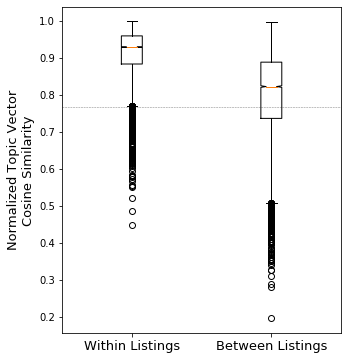

In [525]:
flat_df = evaluate_topics(fdf = flat_df, lda_dict = lda08_st10_sb1000_dict, 
      n_revs_per_listing= n_revs_per_listing, min_revs= 20, corpus_key_name='corpus08_st10_sb1000')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


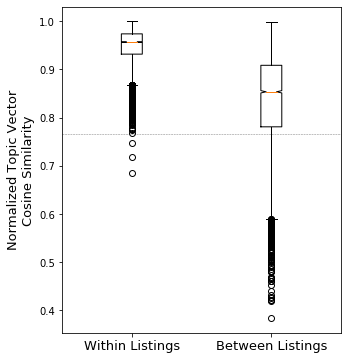

ValueError: too many values to unpack (expected 3)

In [527]:
flat_df, sw40, sb40 = evaluate_topics(fdf = flat_df, lda_dict = lda08_st10_sb1000_dict, 
      n_revs_per_listing= n_revs_per_listing, min_revs= 10, corpus_key_name='corpus08_st10_sb1000')

In [550]:
def assign_topic_score_to_df(fdf, flat_pickle_name, 
                             rdb, clean_scored_room_db_pickle_name,
                             lda_dict,
                             corpus_key_name, norm):
    
    model = lda_dict['model']
    topics = lda_dict['topics']
    dictionary = lda_dict['dictionary']
    corpus = lda_dict['corpus']
    n_topics=len(topics)
    
    fdf_listing_ids = np.unique(fdf.listing_id)
    
    # calculate the topic vector of every comment
    # on the basis of flat_df.corpus10_st_05_sb1000_NEW
    corpus_scores = fdf[corpus_key_name]
    fdf['topic_scores'] = corpus_scores.apply(lambda c: get_topic_score(c,  
                                                                        model,
                                                                        n_topics,
                                                                       norm))
    fdf['topic_scores_unnormalized'] = corpus_scores.apply(lambda c: get_topic_score(c, 
                                                                                      model,
                                                                                      n_topics,
                                                                                     norm))
    with open(flat_pickle_name, 'wb') as pickle_file:
        pickle.dump(fdf, pickle_file)


    # now restack this df by listing_id
    clean_scored_room_db = deepcopy(rdb).sort_values(by=['room_id'])
    fdf_s = fdf.sort_values(by = ['listing_id'])

    topic_scores_arr = np.zeros((clean_scored_room_db.shape[0]), dtype=object)
    topic_scores_unnormalized_arr = np.zeros((clean_scored_room_db.shape[0]), dtype=object)
    for i, lid in enumerate(clean_scored_room_db.room_id):

        if lid in fdf_listing_ids:
            this_df = fdf_s[fdf_s.listing_id == lid]
            topic_scores_arr[i] = np.vstack(this_df.topic_scores)
            topic_scores_unnormalized_arr[i] = np.vstack(this_df.topic_scores_unnormalized)
        else:
            topic_scores_arr[i] = np.nan
            topic_scores_unnormalized_arr[i] = np.nan

    clean_scored_room_db['topic_scores'] = topic_scores_arr
    clean_scored_room
    _db['topic_scores_unnormalized'] = topic_scores_unnormalized_arr
    clean_scored_room_db = clean_scored_room_db.dropna(subset = ['topic_scores', 'topic_scores_unnormalized'])
    clean_scored_room_db['mean_topic_score'] = \
        clean_scored_room_db['topic_scores'].apply(lambda x: np.mean(x, axis=0))
    clean_scored_room_db['mean_topic_score_unnormalized'] = \
        clean_scored_room_db['topic_scores_unnormalized'].apply(lambda x: np.mean(x, axis=0))
    
    return clean_scored_room_db

In [ ]:
lda08_st10_sb1000_dict

In [537]:
lda08_st10_sb1000_dict['topics']

[(0,
  '0.055*"look" + 0.038*"valu" + 0.037*"exact" + 0.032*"pictur" + 0.031*"expect" + 0.030*"better" + 0.027*"price" + 0.027*"transport" + 0.026*"describ" + 0.021*"public"'),
 (1,
  '0.060*"station" + 0.055*"minut" + 0.044*"train" + 0.036*"away" + 0.025*"metro" + 0.024*"near" + 0.020*"conveni" + 0.020*"squar" + 0.018*"block" + 0.017*"line"'),
 (2,
  '0.025*"night" + 0.017*"sleep" + 0.012*"littl" + 0.012*"door" + 0.012*"nois" + 0.011*"issu" + 0.011*"thing" + 0.010*"peopl" + 0.010*"floor" + 0.010*"airbnb"'),
 (3,
  '0.064*"park" + 0.034*"shop" + 0.031*"central" + 0.027*"food" + 0.026*"street" + 0.022*"coffe" + 0.020*"block" + 0.020*"store" + 0.019*"nearbi" + 0.018*"lot"'),
 (4,
  '0.040*"beauti" + 0.036*"amaz" + 0.023*"decor" + 0.022*"brooklyn" + 0.022*"stylish" + 0.020*"view" + 0.017*"wonder" + 0.016*"spacious" + 0.015*"spot" + 0.015*"cool"'),
 (5,
  '0.030*"welcom" + 0.023*"feel" + 0.022*"hous" + 0.021*"experi" + 0.021*"amaz" + 0.020*"come" + 0.019*"kind" + 0.018*"york" + 0.018*"best

In [538]:
inds = [0, 5, 7, 8, 9]
scores = [0.0707859,  0.16742381, 0.45757493, 0.18526804, 0.09262669]
np.zeros((8))[inds] = scores

IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:
lda08_st10_sb1000_dict

'/Users/bennett/Documents/GitHub/airbnb_insight_repo/airbnb_insight/Flask/MVP/csrdb.pkl'

In [551]:
flaskdir = '/Users/bennett/Documents/GitHub/airbnb_insight_repo/airbnb_insight/Flask/MVP/'
clean_scored_room_db = assign_topic_score_to_df(fdf = flat_df,
                                    flat_pickle_name= flaskdir + 'fdf.pkl',
                                    lda_dict=lda08_st10_sb1000_dict,
                                    rdb=room_db,
                                    clean_scored_room_db_pickle_name = flaskdir + 'csrdb.pkl',
                                    norm=True,
                                    corpus_key_name='corpus08_st10_sb1000')

In [552]:
pf = flaskdir + 'csrdb.pkl'
with open(pf, 'wb') as pickle_file:
        pickle.dump(clean_scored_room_db, pickle_file)

In [553]:
hi1 = clean_scored_room_db[clean_scored_room_db.mean_topic_score.apply(lambda x: x[1] > 0.25)]
hi1hi2 = hi1[hi1.mean_topic_score.apply(lambda x: x[2] > 0.25)]

In [571]:
fdf_with_misfortune2 = flat_df[flat_df.comments.apply(lambda x: 'unfortunately' in x)]

In [579]:
for i in range(200):
    print(1000+i, fdf_with_misfortune2.topic_scores.iloc[1000 + i], '\n')

1000 [0.28794462 0.         0.53988648 0.61929794 0.         0.
 0.49201682 0.        ] 

1001 [0.         0.90363493 0.31646933 0.14152071 0.20486197 0.
 0.         0.1459265 ] 

1002 [0.         0.         0.8874054  0.10690725 0.40937428 0.
 0.18301691 0.        ] 

1003 [0.64952153 0.02238134 0.36026398 0.02237332 0.02237522 0.66770329
 0.02237219 0.02238985] 

1004 [0. 0. 1. 0. 0. 0. 0. 0.] 

1005 [0.         0.39383444 0.74672333 0.         0.         0.42569209
 0.25136007 0.20713055] 

1006 [0.         0.27700853 0.76403629 0.47280623 0.30187382 0.
 0.1576112  0.        ] 

1007 [0.         0.28188542 0.55791863 0.         0.6754469  0.39120187
 0.         0.        ] 

1008 [0.         0.         0.8945587  0.         0.         0.40222969
 0.19487435 0.        ] 

1009 [0.         0.49094742 0.78061203 0.         0.         0.
 0.3868016  0.        ] 

1010 [0.         0.24183941 0.91656612 0.18935659 0.         0.25605532
 0.         0.        ] 

1011 [0.         0.        

In [581]:
hi1hi2 = fdf_with_misfortune2[fdf_with_misfortune2.topic_scores.apply(lambda x: x[1] > .4 and x[2] > .4)]

In [595]:
hi1hi2.iloc[150].comments

"We had a great stay at HOST_NAME's place.  With the incessant rain there was a  a fly epidemic during our stay and then unfortunately a flood in the bedroom.  HOST_NAME was very responsive on both situations and kindly offered too reimburse us  for the trouble, which is over and above any other airbnb host we have ever had.   The place itself is in a quiet safe street with a couple of minute walk up to 5th street where there are restaurants/cafes and pretty much anything you need.  The subway is relatively close by.  Everything is in walking distance.  The apartment is clean, beautifully furnished and well equipped with anything you pretty much need.     I would definitely stay here again  and if you want a nice area in Brooklyn then this is the place for you.  Thanks HOST_NAME."

In [594]:
clean_scored_room_db[clean_scored_room_db.room_id == 32839377].comments.values

array([list(['Perfect place for 4 guests! Spacious for a New York spot. walking distance from stores and subway', 'Very nice tiny apartment close to the subway and supermarket. Very friendly host and very good communication. Thank you for the stay', 'Great place very spacious', 'Anastasia était une super hôte, très réactive et à l’ecoute de nos besoins.\nL’appartement est très propre et convenable!', 'This was a great stay in a spacious place, very close to the delights of the slope. Thanks a lot!', 'Beautiful Cosy apartment ! Really spacious and clean. 30min away from manhattan and free parking on the street !', 'Beautiful lower level apartment. Very quiet and easy to access.', 'The apartment was a clean and well furnished. The location was great. The host was very responsive and accommodating.', 'Anastasia is one efficient and warm person who I did not have the privilege of meeting in person. She is quick and precise with her responses and there is no wait and see! Her place is a hom

within_greater = sims_within[sims_within > sims_between]
between_greater = sims_between[sims_within <= sims_between]

(len(within_greater)/len(sims_within))

In [484]:
(0.8401436142930415) / .5

1.680287228586083

In [ ]:
# How much better than chance are we?
# Approach: compare topics 

In [614]:
np.mean(sims_random_norm, axis=0)

0.7670089074038959

In [439]:
fdf_with_misfortune = \
    flat_df[flat_df.comments.apply(lambda x: 'unfortunately' in x)]
fdf_with_trendy = \
    flat_df[flat_df.comments.apply(lambda x: 'trendy' in x)]
fdf_with_peaceful = \
    flat_df[flat_df.comments.apply(lambda x: 'peaceful' in x)]

In [ ]:
np.mean(fdf_with_trendy)

In [593]:
fdf_with_misfortune.comments.iloc[2]

"cin is such a beautiful person, i really enjoyed her company. her apartment is a bit far but very well connected, just 100 meters from a well connected subway line. its perfect for a long holiday in ny. i wanted to extend my stay but unfortunately it was all pre-booked. i wish to see you again cin, you know who to call when you're in new delhi."

In [610]:
i = 8
df = fdf_with_trendy
c = list(df.corpus10_st_05_sb1000)[i]
text = list(df.comments)[i]
tvec_trend = get_topic_score(c, model, n_topics=8, norm=True)
print(list(tvec_trend))
print(text)

[0.3776506882673125, 0.0, 0.15832379493796708, 0.23224584372679816, 0.0, 0.3376106870619816, 0.7822515241591198, 0.09398520113469366, 0.208910891480639, 0.0]
a.  the location    dave and rick's place is situated in what is probably one of the best locations you can choose in nyc, especially if, like us, you're a first time visitor trying to get your bearings. step out of their apartment; walk one way and you're suddenly in the heart of the west village and gorgeous bleecker street. walk the other and you step in to trendy chelsea with its glorious eateries; or take yet another direction and you find yourself on the highline promenade along the hudson river.  additionally, on the opposite end of their block you'll find a subway station connecting you to the blue a, c and e lines.  there is an abundance of wonderful restaurants and diners within a 5-minute walking radius, suiting every sort of budget, that mike and i were very much spoilt for choice at most mealtimes.   really, the locat

1000
1001


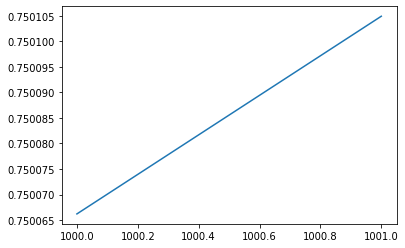

In [647]:
mean_sims = []
for i in range(1000, 1002):
    print(i)
    these_sims = []
    for j in range(100000):
        r1 = np.random.uniform(low=0, high=1.0, size=i)
        r2 = np.random.uniform(low=0, high=1.0, size=i)
        these_sims.append(cosine_similarity(r1, 
                                            r2))
    mean_sims.append(np.mean(these_sims))
plt.plot(range(1000, 1002), mean_sims)
plt.show()
        

In [648]:
mean_sims

[0.7500662007024224, 0.7501048939968434]

In [635]:
print(np.median(sims_within), np.median(sims_between))
print(sc.stats.mannwhitneyu(sims_within, sims_between))


0.9280215524870081 0.8049345864754155
MannwhitneyuResult(statistic=2180337.0, pvalue=0.0)


In [620]:
sims_within_norm

array([0., 0., 0., ..., 0., 0., 0.])

In [626]:
0.7670089074038959**

0.9738230294695316

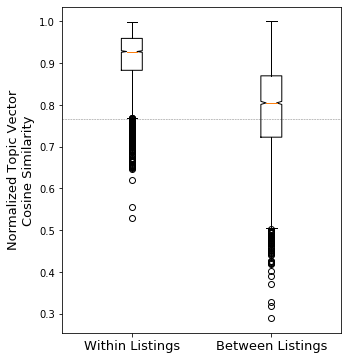

In [623]:
plt.figure(1, (5, 6))
plt.boxplot([sims_within, sims_between], notch = True)
plt.gca().set_xticklabels(['Within Listings', 'Between Listings'], fontsize=13)
plt.ylabel('Normalized Topic Vector\nCosine Similarity', fontsize=13)
plt.gca().axhline(0.7670089074038959, ls='--', lw=0.5, alpha=0.5, c='k')



In [441]:
flat_df.corpus10_st_05_sb1000_NEW

2          [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
3          [(8, 1), (15, 1), (16, 1), (17, 1), (18, 1), (...
4                                 [(8, 1), (23, 1), (24, 1)]
5          [(8, 2), (15, 1), (18, 1), (25, 1), (26, 1), (...
6                        [(8, 1), (34, 1), (35, 1), (36, 1)]
                                 ...                        
1143027                                           [(473, 1)]
1143028    [(113, 1), (221, 1), (224, 1), (298, 1), (458,...
1143029                       [(659, 1), (780, 1), (941, 1)]
1143030                       [(277, 1), (367, 1), (738, 1)]
1143032    [(4, 1), (19, 1), (56, 1), (107, 1), (113, 1),...
Name: corpus10_st_05_sb1000_NEW, Length: 889248, dtype: object

In [596]:
clean_scored_room_db.mean_topic_score.iloc[0]

array([0.08566015, 0.22303034, 0.29497779, 0.06787513, 0.36609403,
       0.25946266, 0.0465094 , 0.22226811])

In [444]:
pickle_name = '../Flask/Airbnb/MVP/new_clean_scored_room_db.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)
    


../Flask/Airbnb/MVP/new_clean_scored_room_db.pkl


In [449]:
lda_10_less05_great1000_NEW = {}
lda_10_less05_great1000_NEW['model'] = lda10_st_05_sb1000_NEW
lda_10_less05_great1000_NEW['dictionary'] = dictionary10_st_05_sb1000_NEW
lda_10_less05_great1000_NEW['corpus'] = corpus10_st_05_sb1000_NEW
lda_10_less05_great1000_NEW['topics'] = topics10_st_05_sb1000_NEW

with open('../Flask/Airbnb/MVP/lda_10_less05_great1000_NEW.pkl', 'wb') as pickle_file:
    pickle.dump(lda_10_less05_great1000_NEW, pickle_file)

In [452]:
# get the rest of the columns
listings_nyc_sorted = listings[0].sort_values(by = 'room_id')
listings_nyc_sorted_clean = listings_nyc_sorted[listings_nyc_sorted.room_id.isin(clean_scored_room_db.room_id)]
rest_of_cols = sorted([c for c in listings_nyc_sorted.columns if c not in clean_scored_room_db.columns])
clean_scored_room_db[rest_of_cols] = listings_nyc_sorted_clean[rest_of_cols]

pickle_name = '../Flask/Airbnb/MVP/new_clean_scored_room_db.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../Flask/Airbnb/MVP/new_clean_scored_room_db.pkl


In [617]:
def screen_comments(comment_list, min_words = 10, lang_condition = 'en'):
    """
    Input: a list of comments
    
    Output: a list of comments that abide the following rules:
    nans are filled with empy strings ` fillna('') `
    The comments are in english
    The comments have at least 10 words
    "The host canceled this reservation" reviews are removed
    """
    
    # remove nams
    screened = [c for c in comment_list if c and c==c]
    
    #screen
    screened = [c for c in clean_comment_list(screened) if len(c.split(' ')) >= min_words
                                                            and clean_detect(c) == lang_condition
                                                            and c [:34] != 'The host canceled this reservation']
    return screened


def clean_comment_list(clist):
    clist_clean = []
    for i, c in enumerate(clist):
        cclean = c.replace('\n', ' ')
        cclean = cclean.replace('\r', ' ')
        clist_clean.append(cclean)
    return clist_clean

screened_comments = clean_scored_room_db.comments.apply(lambda x: screen_comments(x))
clean_scored_room_db['comments_screened'] = screened_comments

pickle_name = '../Flask/Airbnb/MVP/csrdb.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../Flask/Airbnb/MVP/csrdb.pkl


In [645]:
room_df.room_id

0            2515
1            2595
3            4611
4            5099
5            5172
           ...   
19369    18413899
19375    18423403
19382    18426417
19406    18443436
19483    18491399
Name: room_id, Length: 14447, dtype: int64

In [646]:
clean_scored_room_db.room_id

0            2595
2            3831
3            5022
4            5099
5            5121
           ...   
48636    37367709
48683    37400191
48685    37400410
48694    37416939
48745    37447887
Name: room_id, Length: 36686, dtype: int64

In [648]:
listings[0].room_id

0            2595
1            3647
2            3831
3            5022
4            5099
           ...   
48859    37497806
48860    37497989
48861    37498824
48862    37499051
48863    37499093
Name: room_id, Length: 48864, dtype: int64

In [649]:

df = listings[0]
oldcols = [c for c in df.columns if not c in clean_scored_room_db.columns]
clean_scored_room_db[oldcols] = df[df.room_id.isin(clean_scored_room_db.room_id)][oldcols]
clean_scored_room_db.room_price = \
    clean_scored_room_db.room_price.apply(lambda x: float(x.replace('$', '').replace(',', '')))

clean_scored_room_db.host_name = clean_scored_room_db.host_name.apply(lambda x: x.values[0])
pickle_name = '/Users/bennett/Documents/Flask/Airbnb/MVP/csrdb.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../Flask/Airbnb/MVP/csrdb.pkl


In [676]:
pickle_name = '/Users/bennett/Documents/Flask/Airbnb/MVP/csrdb.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

/Users/bennett/Documents/Flask/Airbnb/MVP/csrdb.pkl


In [675]:
clean_scored_room_db.room_price = \
    clean_scored_room_db.room_price.apply(lambda x: float(x.replace('$', '').replace(',', '')))
pickle_name = '/Users/bennett/Documents/Flask/Airbnb/MVP/csrdb.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

AttributeError: 'float' object has no attribute 'replace'

In [665]:
len(clean_scored_room_db[clean_scored_room_db.room_id==22815108].comments_screened)

1

In [668]:
print_types(clean_scored_room_db)

NameError: name 'print_types' is not defined

In [667]:
len(clean_scored_room_db[clean_scored_room_db.comments_screened.apply(lambda x: len(x) >= 10)])

17285

In [664]:
len(clean_scored_room_db.comments[0])

46

In [618]:
clean_scored_room_db.comments_screened

0        [I've stayed with my friend at the Midtown Cas...
2        [lisa is a wonderful, kind and thoughtful host...
3        [Great host with a very cute apartment. Easy a...
4        [I had a great experience at Tina's "True NYC ...
5        [Great guy with a basic room. Clean sheets and...
                               ...                        
48636    [Bed is super comfortable. Host is Polite kind...
48683    [Great host. Very accommodating with our check...
48685    [The place is much better in person. The space...
48694    [Allyson's place was really chill and was a gr...
48745    [I really loved my stay in NYC at Jason's apar...
Name: comments_screened, Length: 36686, dtype: object

In [623]:
(1 - (.5**8))**.125

0.9995108822419678

##### 

In [652]:
clean_scored_room_db.room_price = \
    clean_scored_room_db.room_price.apply(lambda x: float(x.replace('$', '').replace(',', '')))
pickle_name = '../Flask/Airbnb/MVP/csrdb.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)


In [603]:
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../Flask/Airbnb/MVP/lda08_st10_sb1000_dict_NEW.pkl


In [601]:
clean_scored_room_db.mean_topic_score.iloc[0]

array([0.08566015, 0.22303034, 0.29497779, 0.06787513, 0.36609403,
       0.25946266, 0.0465094 , 0.22226811])

In [469]:
clean_scored_room_db.comments_screened.iloc[0][0]

"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York.  Attention: it's on the 4th floor without a lift :-) but definetely worth it!"

In [627]:
from random import gauss

def make_rand_vector(dims):
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

In [634]:
for i in range(7):
    print(np.abs([round(i, 2) for i in make_rand_vector(3)]))
 

[0.56 0.11 0.82]
[0.97 0.12 0.22]
[0.7  0.29 0.65]
[0.31 0.35 0.88]
[0.12 0.99 0.02]
[0.77 0.28 0.57]
[0.47 0.12 0.87]


In [644]:
sorted(room_df.columns)

['access',
 'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'comments',
 'comments_screened',
 'coordinates',
 'country',
 'country_code',
 'date_last_review',
 'description',
 'experiences_offered',
 'extra_people',
 'features',
 'first_review',
 'guests_included',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_id',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'interaction',
 'jurisdiction_names',
 'last_scraped',
 'latitude',
 'license',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'mean_t

In [637]:
.71 / 1.71

0.4152046783625731

In [640]:
dt = np.array([[1, 0], [0, 1], [.5, .5]])
tw1 = np.array([[.5, .5, 0, 0], [0, 0, 0.5, .5]])
tw2 = np.array([[.58, 1, .42, .42], []])
np.dot(dt, tw1)

array([[0.5 , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [0.25, 0.25, 0.25, 0.25]])

In [ ]:
clean_scored_room_db.url

In [472]:
clean_scored_room_db.review_scores_rating

0         95.0
2         90.0
3         93.0
4         89.0
5         90.0
         ...  
48636    100.0
48683    100.0
48685    100.0
48694    100.0
48745    100.0
Name: review_scores_rating, Length: 36686, dtype: float64

In [467]:
np.where(clean_scored_room_db.room_price == np.max(clean_scored_room_db.room_price))

(array([ 7698, 13870]),)

In [456]:
clean_scored_room_db.bed_type

0        Real Bed
2        Real Bed
3        Real Bed
4        Real Bed
5           Futon
           ...   
48636    Real Bed
48683    Real Bed
48685    Real Bed
48694    Real Bed
48745    Real Bed
Name: bed_type, Length: 36686, dtype: object

0        $225.00
2         $89.00
3         $80.00
4        $200.00
5         $60.00
          ...   
48636     $57.00
48683     $60.00
48685    $229.00
48694     $60.00
48745    $312.00
Name: room_price, Length: 36686, dtype: object

In [458]:
np.unique(sorted(clean_scored_room_db.room_type))

array(['Entire home/apt', 'Private room', 'Shared room'], dtype='<U15')

In [750]:
for index, row in flat_df_newclean_HOST_NAME.iteritems():
    print(row)

0             2515
3             2515
4             2515
5             2515
6             2515
            ...   
325676    18413899
325678    18423403
325679    18426417
325680    18443436
325681    18491399
Name: listing_id, Length: 265954, dtype: int64
0              Mizi
3              Mizi
4              Mizi
5              Mizi
6              Mizi
            ...    
325676        Alexa
325678      Shannon
325679    Margarita
325680        Clara
325681        Jerry
Name: host_name, Length: 265954, dtype: object
0              9193
3            185050
4            456184
5            351855
6            363433
            ...    
325676    127641350
325678     43662901
325679     28703397
325680     25112195
325681     16637631
Name: user_id, Length: 265954, dtype: int64
0         stephanie's offered all the most important thi...
3         we stayed at the 111th street apartment with s...
4         very conveniently located just north of centra...
5         we had a great stay wit

In [450]:
sorted(clean_scored_room_db.columns)

['comments',
 'host_name',
 'mean_topic_score',
 'mean_topic_score_unnormalized',
 'room_id',
 'topic_scores',
 'topic_scores_unnormalized',
 'user_id',
 'user_name']

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe415656290>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe259ac3690>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe4156564d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe415656450>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fe220226490>}

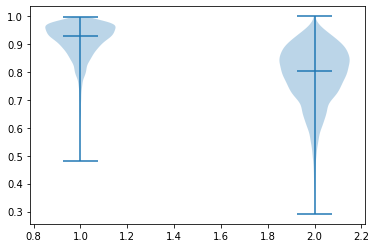

In [573]:
plt.violinplot([sims_within_norm, sims_between_norm], [1, 2], points=500, widths=0.3,
                      showmeans=False, showextrema=True, showmedians=True,)

In [530]:
cosine_similarity([1, 0, 0], [1, 1, 1])

0.5773502691896258

In [472]:
test = np.array(lda10_st_05_sb1000[flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000.iloc[2]])

In [484]:
test[:, 0].astype(int)

array([5, 7, 9])

In [526]:
test2 = np.zeros((10))
test2[test[:, 0].astype(int)] = test[:, 1]
print(test2)
print(norm(test2))
test2_norm = test2/norm(test2)
print(test2_norm)
print(norm(test2_norm))


[0.         0.         0.         0.         0.         0.26887366
 0.         0.33590093 0.         0.33688295]
0.5464545760789359
[0.         0.         0.         0.         0.         0.49203296
 0.         0.61469141 0.         0.61648848]
1.0


In [489]:
norm([0.49203296, 0.61469141 ,0.61648848])

1.00000000461343

In [498]:
norm([0, 0, 0, 0, 0])

0.0

In [478]:
[6, 6] / norm([6, 6])

array([0.70710678, 0.70710678])

In [529]:
np.linalg.norm(np.array([0.24137017, 0.,0.,0.,0.69708091, 0., 0.,0., 0., 0.]))

0.7376864876438073

In [649]:
flat_df_newclean_HOST_NAME.shape

(265954, 5)

In [660]:
a = np.array([1, 0])
b = np.array([[1, 0], [0, 1], [-1, -1]])
cosine_similarity(a, b)

ValueError: shapes (2,) and (3,2) not aligned: 2 (dim 0) != 3 (dim 0)

In [676]:
np.repeat(a[np.newaxis, :], 3, axis=0).shape, b.shape

((3, 2), (3, 2))

In [687]:
np.repeat(a[np.newaxis, :], 3, axis=0), b

(array([[1, 0],
        [1, 0],
        [1, 0]]), array([[ 1,  0],
        [ 0,  1],
        [-1, -1]]))

In [689]:
b.shape

(3, 2)

In [702]:
print(np.dot(a, b.T)/(np.linalg.norm(a)*np.linalg.norm(b.T)),'\n', a, '\n', b.T)

[ 0.5  0.  -0.5] 
 [1 0] 
 [[ 1  0 -1]
 [ 0  1 -1]]


In [710]:
a.shape

(2,)

In [718]:
a.reshape(2, 1).T, b.T

(array([[1, 0]]), array([[ 1,  0, -1],
        [ 0,  1, -1]]))

In [720]:
cosine_similarity(a.T, b.T)

array([ 0.5,  0. , -0.5])

In [665]:
np.linalg.norm(b, axis=1)

array([1.        , 1.        , 1.41421356])

In [679]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [723]:
print(b)
for irow, row in enumerate(b):
    print(row)

[[ 1  0]
 [ 0  1]
 [-1 -1]]
[1 0]
[0 1]
[-1 -1]


In [725]:
flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000

0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
3         [(10, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
4         [(15, 1), (17, 1), (19, 1), (21, 1), (22, 1), ...
5         [(13, 1), (15, 1), (19, 1), (26, 1), (29, 1), ...
6         [(29, 1), (32, 1), (33, 1), (34, 1), (35, 1), ...
                                ...                        
325676              [(41, 1), (196, 1), (236, 1), (325, 1)]
325678    [(46, 1), (84, 1), (130, 1), (153, 1), (242, 1...
325679                                            [(58, 1)]
325680                       [(470, 1), (487, 1), (531, 1)]
325681    [(76, 1), (95, 1), (145, 1), (187, 1), (221, 1...
Name: corpus10_st_05_sb1000, Length: 265954, dtype: object

In [759]:
flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000

0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
3         [(10, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
4         [(15, 1), (17, 1), (19, 1), (21, 1), (22, 1), ...
5         [(13, 1), (15, 1), (19, 1), (26, 1), (29, 1), ...
6         [(29, 1), (32, 1), (33, 1), (34, 1), (35, 1), ...
                                ...                        
325676              [(41, 1), (196, 1), (236, 1), (325, 1)]
325678    [(46, 1), (84, 1), (130, 1), (153, 1), (242, 1...
325679                                            [(58, 1)]
325680                       [(470, 1), (487, 1), (531, 1)]
325681    [(76, 1), (95, 1), (145, 1), (187, 1), (221, 1...
Name: corpus10_st_05_sb1000, Length: 265954, dtype: object

In [815]:
type(flat_df_newclean_HOST_NAME.topic_scores.iloc[0])

numpy.ndarray

In [837]:
test = 

In [838]:
np.vstack(corpus_scores.iloc[:6].apply(lambda c: get_topic_score(c, model,n_topics=10,norm=True)))

(6, 10)

In [840]:
test = pd.DataFrame({'a':[0, 1, 2, 3, 4, 5],
                     'b': corpus_scores.iloc[:6].apply(lambda c: get_topic_score(c, model,n_topics=10,norm=True))})


In [842]:
np.vstack(test.b)

array([[0.32527584, 0.        , 0.        , 0.        , 0.94561918,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.14516399, 0.20241641, 0.        , 0.        ,
        0.        , 0.        , 0.57773628, 0.        , 0.77728747],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49206235, 0.        , 0.61467977, 0.        , 0.61647662],
       [0.01926908, 0.01926971, 0.01926839, 0.01926877, 0.01926925,
        0.23578378, 0.01927031, 0.22732675, 0.01926927, 0.94346671],
       [0.        , 0.        , 0.17255872, 0.        , 0.        ,
        0.63367925, 0.        , 0.        , 0.25038584, 0.71132343],
       [0.        , 0.18159151, 0.3844523 , 0.        , 0.879195  ,
        0.        , 0.        , 0.        , 0.        , 0.21502815]])

In [ ]:
corpus_scores.apply(lambda c: get_topic_score(c, 


In [856]:
room_db.shape, room_db.columns

((19528, 4),
 Index(['room_id', 'host_name', 'user_id', 'comments'], dtype='object'))

In [858]:
flat_df_newclean_HOST_NAME.columns

Index(['listing_id', 'host_name', 'user_id', 'comments',
       'corpus10_st_05_sb1000', 'topic_scores', 'topic_scores_unnormalized'],
      dtype='object')

0             2515
3             2515
4             2515
5             2515
6             2515
            ...   
325676    18413899
325678    18423403
325679    18426417
325680    18443436
325681    18491399
Name: listing_id, Length: 265954, dtype: int64

In [865]:
fdf_s = flat_df_newclean_HOST_NAME.sort_values(by = ['listing_id'])
test = fdf_s.listing_id.apply(lambda lid: np.vstack(fdf_s[fdf_s.listing_id == lid].topic_scores))

In [868]:
test[0].shape

(107, 10)

In [870]:
type(test)

pandas.core.series.Series

In [883]:
test2 = pd.DataFrame({'a': np.array([0, 1, 2])})
b_empty = np.zeros(test2.shape[0])
b_empty[:] = np.nan
test2['b'] = b_empty
test2[test2.a == 2].b = 44
test2

/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,a,b
0,0,NaN
1,1,NaN
2,2,NaN


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [894]:
clean_scored_room_db.columns

Index(['room_id', 'host_name', 'user_id', 'comments', 'topic_scores',
       'topic_scores_unnormalized', 'mean_topic_score',
       'mean_topic_score_unnormalized'],
      dtype='object')

In [895]:
pickle_name = datadir + 'clean_scored_room_db.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../../Desktop/Insight Project/airbnb/pickles/clean_scored_room_db.pkl


(19528, 89)

In [935]:
type(listings[0])

pandas.core.frame.DataFrame

In [938]:
pickle_name = datadir + 'clean_scored_room_db.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../../Desktop/Insight Project/airbnb/pickles/clean_scored_room_db.pkl


In [939]:
clean_scored_room_db.shape

(14447, 95)

In [925]:
reviews.shape

(8348173, 6)

0    [hat, list, multipl, problem, unfortun, return...
1       [appart, trendi, neighborhood, love, nightlif]
2                                [decor, modern, chic]
3        [janet, warm, bubbl, real, treat, hang, ador]
Name: comments, dtype: object

In [1127]:
list(fake_rev_df.comments.map(preprocess))

[['hat', 'list', 'multipl', 'problem', 'unfortun', 'return', 'joke'],
 ['appart', 'trendi', 'neighborhood', 'love', 'nightlif'],
 ['decor', 'modern', 'chic'],
 ['janet', 'warm', 'bubbl', 'real', 'treat', 'hang', 'ador']]

[0.0200021,
 0.22040394,
 0.020000447,
 0.02000929,
 0.020001652,
 0.020008553,
 0.020000195,
 0.02000008,
 0.61957276,
 0.020001013]

In [1173]:
sims[0].shape

(14447,)

In [1211]:
comment_bow

[(22, 1), (183, 1), (289, 1), (299, 1)]

In [106]:
clean_scored_room_db.test_similarity

0        0.584640
1        0.390258
3        0.545825
4        0.314289
5        0.234685
           ...   
19369    0.101561
19375    0.323929
19382    0.140803
19406    0.072174
19483    0.078621
Name: test_similarity, Length: 14447, dtype: float64

In [109]:
np.shape(sk.metrics.pairwise.cosine_similarity(np.array(comment_topic_vector).reshape(1, -1),
                                      clean_scored_room_db.topic_scores.iloc[0]))

(1, 107)

In [113]:

lda10_st_05_sb1000 = lda_10_less05_great1000['model']
topics10_st_05_sb1000 = lda_10_less05_great1000['topics']
corpus10_st_05_sb1000 = lda_10_less05_great1000['corpus']
dictionary10_st_05_sb1000 = lda_10_less05_great1000['dictionary']

comment = "Public Transit Subway Metro Central Park."
comment_bow = dictionary10_st_05_sb1000.doc2bow(preprocess(comment))
comment_topic_vector = [tup[1] for tup in lda10_st_05_sb1000[comment_bow]]
print(comment_topic_vector)

sims = sk.metrics.pairwise.cosine_similarity(np.array(comment_topic_vector).reshape(1, -1),
                                      np.vstack(clean_scored_room_db.mean_topic_score))
clean_scored_room_db['test_similarity'] = sims[0]
sorted_rooms = clean_scored_room_db.sort_values(by = 'test_similarity', ascending = False)
the_result = sorted_rooms
#the_result = sorted_rooms[sorted_rooms.comments.apply(lambda x : len(x) >= 10)].iloc[:3]

print(comment, '\n')
for i in range(3):
    clist = the_result.iloc[i]
    print(i, clist.test_similarity)
    for c in clist.comments:
        print(c)
    print('\n')

[0.025000002, 0.025000036, 0.025000006, 0.025000002, 0.025000002, 0.025000017, 0.025000002, 0.025000002, 0.025000175, 0.7749998]
Public Transit Subway Metro Central Park. 

0 0.9999999999560636
The apartment was small but cosy. It has all the necessities you might need for a stay as a couple or as 2 friends. The location is perfect. There are a supermarket, restaurants, and bars close by. There also are 2 subway station close by ( less than 300m).


1 0.9999999999543647
Such a great little place to spend our holiday. Easy access to everything. Safe and great neighbourhood. Noelia was a fanatic host with great communication! Will stay there again !


2 0.9999999998969676
Read my other review.
Excelente edificio y ubicación. Limpio y ordenado. Pequeño pero cómodo.
Todo es como se describe y se descansa bien porque hay silencio y una buena cama. 
La ubicación es perfecta, para dos metros y par ir a Central Park o pasear por la zona a pie y descubrir bares y restaurantes muy variados y de 

In [115]:
 
def compute_similarity(arr, comment_topic_vector):
    return sk.metrics.pairwise.cosine_similarity(np.array(comment_topic_vector).reshape(1, -1), arr)

comment = "Public Transit Subway Metro Central Park."
comment_bow = dictionary10_st_05_sb1000.doc2bow(preprocess(comment))
comment_topic_vector = [tup[1] for tup in lda10_st_05_sb1000[comment_bow]]
print(comment_topic_vector)

these_listings = clean_scored_room_db.topic_scores
elementwise_sims = these_listings.apply(lambda x: compute_similarity(x, comment_topic_vector))
clean_scored_room_db['test_elementwise_similarity'] = elementwise_sims

[0.025000002, 0.025000036, 0.025000006, 0.025000002, 0.025000002, 0.025000017, 0.025000002, 0.025000002, 0.025000175, 0.7749998]


In [121]:
tr1 = clean_scored_room_db.iloc[1]
tr1.comments[np.argmax(tr1['test_elementwise_similarity'])]

"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!"

In [ ]:
mssc = clean_scored_room_db.test_elementwise_similarity.apply()

In [1147]:
fake_revs = ["I hated this listing. It had multiple problems. Unfortunately, I won't be returning. What a joke.",
"This appartment was in a very trendy neighborhood. I loved the nightlife.",
"The decor was so modern and chic!",
 "Janet was so warm and bubbly. It was a real treat to hang out with her and her adorable cat",
"I had a horrible time. The refrigerator did not work. The house was too warm and too muggy. Do not recommend!",
"A perfect quiet apartment. It was so private. I loved reading in the living room",
"I cannot overstate my hatred of this house. I disliked it. Never coming back lol.",
"Stephen was such a warm host. I felt like a part of his family. We talked every morning about his cats"]
fake_rev_df = pd.DataFrame({'comments':fake_revs})
fake_rev_df.comments.map(preprocess)
tvs = []
for comment in list(fake_rev_df.comments.map(preprocess)):
    c = dictionary10_st_05_sb1000.doc2bow(comment)
    print(comment, '\n', lda10_st_05_sb1000[c],'\n\n')
    tvs.append([tup[1] for tup in lda10_st_05_sb1000[c]])

['hat', 'list', 'multipl', 'problem', 'unfortun', 'return', 'joke'] 
 [(0, 0.016676072), (1, 0.016666675), (2, 0.84997946), (3, 0.016666712), (4, 0.016668115), (5, 0.016666887), (6, 0.016670438), (7, 0.016668795), (8, 0.016670177), (9, 0.016666686)] 


['appart', 'trendi', 'neighborhood', 'love', 'nightlif'] 
 [(0, 0.03333333), (1, 0.36666667), (2, 0.03333333), (3, 0.36666664), (4, 0.03333333), (5, 0.03333333), (6, 0.03333333), (7, 0.03333333), (8, 0.03333333), (9, 0.03333333)] 


['decor', 'modern', 'chic'] 
 [(0, 0.699976), (1, 0.03333532), (2, 0.033333335), (3, 0.033336762), (4, 0.033333782), (5, 0.033340503), (6, 0.03333338), (7, 0.03333769), (8, 0.03333983), (9, 0.033333335)] 


['janet', 'warm', 'bubbl', 'real', 'treat', 'hang', 'ador'] 
 [(0, 0.63879126), (1, 0.016667148), (2, 0.016666671), (3, 0.016669314), (4, 0.016672518), (5, 0.22785975), (6, 0.016669324), (7, 0.016666679), (8, 0.01667011), (9, 0.016667165)] 


['horribl', 'time', 'refriger', 'work', 'hous', 'warm', 'muggi',

In [1290]:
len([i for i in ('help     i need somebody       '.split(' ')) if i])

4

In [1292]:
flat_df_newclean_HOST_NAME['comments']

0         stephanie's offered all the most important thi...
3         we stayed at the 111th street apartment with s...
4         very conveniently located just north of centra...
5         we had a great stay with stephanie and her fam...
6         we stayed at the chez chic budget room for a w...
                                ...                        
325676    excellent location, comfy bed, and privacy. ho...
325678    great experience! apartment was clean and tidy...
325679    margarita is the perfect host. we very much en...
325680    clara is a great person, the place below the h...
325681    jerry was a great host! the linens were clean,...
Name: comments, Length: 265954, dtype: object

In [1303]:
'The host canceled this reservation'[:33]

'The host canceled this reservatio'

False

In [38]:
len(clean_scored_room_db.comments.iloc[0])

152

In [39]:
np.shape(clean_scored_room_db.topic_scores.iloc[0])

(107, 10)

In [40]:
pickle_name = '/Users/bennett/Desktop/Insight Project/airbnb/pickles/flat_df_newclean_HOST_NAME.pkl'
with open(pickle_name, 'rb') as pickle_file:
    flat_df_newclean_HOST_NAME = pickle.load(pickle_file)

In [43]:
np.shape(flat_df_newclean_HOST_NAME[flat_df_newclean_HOST_NAME.listing_id == 2515].comments)


(107,)

In [ ]:
'/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.json'
    

In [54]:
clean_scored_room_db.comments.dropna().apply(lambda x: [len(i) for i in x if i])[0]

[337,
 34,
 113,
 478,
 565,
 268,
 673,
 980,
 232,
 485,
 82,
 274,
 88,
 165,
 1114,
 339,
 1179,
 289,
 497,
 580,
 286,
 27,
 226,
 320,
 562,
 108,
 326,
 385,
 70,
 509,
 322,
 439,
 570,
 356,
 576,
 170,
 282,
 488,
 983,
 783,
 147,
 533,
 297,
 956,
 617,
 488,
 430,
 581,
 589,
 1286,
 258,
 125,
 776,
 419,
 411,
 211,
 472,
 160,
 343,
 215,
 348,
 421,
 296,
 255,
 5,
 280,
 250,
 353,
 310,
 33,
 231,
 723,
 392,
 484,
 576,
 417,
 498,
 642,
 464,
 589,
 385,
 224,
 348,
 82,
 457,
 128,
 169,
 374,
 337,
 300,
 172,
 56,
 149,
 285,
 615,
 370,
 2642,
 87,
 162,
 179,
 279,
 431,
 387,
 346,
 343,
 605,
 110,
 140,
 216,
 541,
 43,
 88,
 80,
 106,
 1233,
 233,
 489,
 99,
 596,
 27,
 382,
 78,
 124,
 85,
 164,
 1168,
 927,
 484,
 170,
 196,
 367,
 127,
 558,
 55,
 220,
 88,
 179,
 103,
 376,
 192,
 230,
 77,
 669,
 204,
 107,
 373,
 288,
 456,
 416,
 185,
 146]

In [56]:
if np.nan and np.nan == np.nan:
    print(3)
else:
    print(4)

4


In [ ]:
clean_scored_room_db.mean_

In [310]:
clean_scored_room_db.drop(columns=['embedded', 
                                   'mean_embedded', 
                                   'topic_x_embedded',
                                   'mean_topic_x_embedded']).to_json('/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.json', 
                                 orient='columns')

In [311]:
pwd

'/Users/bennett/Documents/GitHub'

In [275]:
pickle_name

'/Users/bennett/Desktop/Insight Project/airbnb/pickles/flat_df_newclean_HOST_NAME.pkl'

In [276]:
pickle_name = '/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

In [283]:
nlp2 = spacy.blank('en')

In [287]:
import spacy
bytes_data = nlp.to_bytes()
lang = nlp.meta["lang"]

nlp2 = spacy.blank(lang)
nlp2.from_bytes(bytes_data)

TypeError: __init__() got an unexpected keyword argument 'encoding'

In [284]:
nlp.to_bytes().to_disk('/Users/bennett/Documents/Flask/Airbnb/MVP/nlp')
nlp2 = spacy.blank('en')
nlp2_bytes = English().from_bytes('/Users/bennett/Documents/Flask/Airbnb/MVP/nlp')
nlp2.from_bytes(nlp2_bytes)

TypeError: __init__() got an unexpected keyword argument 'encoding'

In [281]:
bytes_data = nlp.to_bytes()
with open('/Users/bennett/Documents/Flask/Airbnb/MVP/nlp_bytes.pkl', 'wb') as pf:
    pickle.dump(nlp_bytes, pf)

TypeError: __init__() got an unexpected keyword argument 'encoding'

In [123]:
room_df = deepcopy(clean_scored_room_db)
lengths = []
for i, j in zip(list(room_df.comments_screened), list(room_df.topic_scores)):
    lengths.append([len(i), np.shape(j)[0]])
lengths = np.array(lengths)
room_df['minimum_length'] = np.min(lengths, axis=1)

In [136]:
room_df.comments_screened

0        [Stephanie's offered all the most important th...
1        [We've been staying here for about 9 nights, e...
3        [Very easy experiance.  Cindy was great to dea...
4        [My girlfriend and me had a wonderful time at ...
5        [Adrienne's apartment is very nice and clean. ...
                               ...                        
19369    [One of the best NYC apartments I've ever been...
19375    [Great experience! Apartment was clean and tid...
19382    [margarita is the perfect host. we very much e...
19406    [Clara is a great person, the place below the ...
19483    [Jerry was a great host! The linens were clean...
Name: comments_screened, Length: 14447, dtype: object

In [138]:
np.random.randint(low=0, high=4, size=20)

array([0, 2, 3, 1, 0, 2, 2, 0, 1, 3, 0, 2, 0, 0, 3, 0, 1, 3, 0, 0])

In [141]:
room_df.comments_screened

0        [Stephanie's offered all the most important th...
1        [We've been staying here for about 9 nights, e...
3        [Very easy experiance.  Cindy was great to dea...
4        [My girlfriend and me had a wonderful time at ...
5        [Adrienne's apartment is very nice and clean. ...
                               ...                        
19369    [One of the best NYC apartments I've ever been...
19375    [Great experience! Apartment was clean and tid...
19382    [margarita is the perfect host. we very much e...
19406    [Clara is a great person, the place below the ...
19483    [Jerry was a great host! The linens were clean...
Name: comments_screened, Length: 14447, dtype: object

In [140]:
room_df.apply(lambda x: x.comments[np.random.randint(low=0, high=len(x.comments))], axis=1)

0        Superbe appartement. En revanche, attention, l...
1        Jennifer's place was in a great midtown locati...
3        Thank you Cin for providing accommodation for ...
4        it was a pleasure to meet tina and to be gast ...
5        Adrienne's place is superb! It is clean, comfo...
                               ...                        
19369    One of the best NYC apartments I've ever been ...
19375    Great experience! Apartment was clean and tidy...
19382    margarita is the perfect host. we very much en...
19406    Clara is a great person, the place below the h...
19483    Jerry was a great host! The linens were clean,...
Length: 14447, dtype: object

In [148]:
# spacy language model


nlp = spacy.load('en_vectors_web_lg')
doc_text = clean_scored_room_db.comments_screened[0][0]
doc = nlp(doc_text)
print(doc.vector)


0        [Stephanie's offered all the most important th...
1        [We've been staying here for about 9 nights, e...
3        [Very easy experiance.  Cindy was great to dea...
4        [My girlfriend and me had a wonderful time at ...
5        [Adrienne's apartment is very nice and clean. ...
                               ...                        
19369    [One of the best NYC apartments I've ever been...
19375    [Great experience! Apartment was clean and tid...
19382    [margarita is the perfect host. we very much e...
19406    [Clara is a great person, the place below the ...
19483    [Jerry was a great host! The linens were clean...
Name: comments_screened, Length: 14447, dtype: object

In [184]:
clean_scored_room_db.topic_scores[0][0]

[0.3251676504, 0.0, 0.0, 0.0, 0.9456563853000001, 0.0, 0.0, 0.0, 0.0, 0.0]

In [200]:
plt.plot(np.linspace(0, 10, 3000),
    np.ravel(np.dot(np.reshape(clean_scored_room_db.topic_scores[0][0], (10, 1)), doc.vector.reshape(1, 300))))
plt.show()

ValueError: shapes (10,1) and (300,) not aligned: 1 (dim 1) != 300 (dim 0)

In [207]:
np.dot([[4], [5], [6]], np.reshape([1, 2, 3], (1, 3)))

array([[ 4,  8, 12],
       [ 5, 10, 15],
       [ 6, 12, 18]])

In [215]:
np.vstack(clean_scored_room_db.topic_scores[0]).shape
np.reshape(clean_scored_room_db.topic_scores[0], (10, 107)).shape

(10, 107)

In [228]:
np.ravel(np.outer(a, [4, 5, 6]))

array([ 4,  5,  6, 12, 15, 18])

In [226]:
test = clean_scored_room_db.apply(lambda(

SyntaxError: invalid syntax (<ipython-input-226-3d6946df04dc>, line 1)

In [223]:
a = [1, 3]
b = [0, 5]
np.multiply(np.tile(a, len(b)), np.tile(b, len(a)))
#np.multiply(a, b)

array([ 0, 15,  0, 15])

In [240]:
embeds = np.array([[1, 2], [3, 4], [5, 6]])
topics = np.array([[1, 0, 3], [4, 0, 6], [7, 0, 10]])
print(embeds, '\n', topics, '\n', np.outer(topics, embeds))
for i in range(3):
    print(np.outer(topics[i, :], embeds[i, :]))

[[1 2]
 [3 4]
 [5 6]] 
 [[ 1  0  3]
 [ 4  0  6]
 [ 7  0 10]] 
 [[ 1  2  3  4  5  6]
 [ 0  0  0  0  0  0]
 [ 3  6  9 12 15 18]
 [ 4  8 12 16 20 24]
 [ 0  0  0  0  0  0]
 [ 6 12 18 24 30 36]
 [ 7 14 21 28 35 42]
 [ 0  0  0  0  0  0]
 [10 20 30 40 50 60]]
[[1 2]
 [0 0]
 [3 6]]
[[12 16]
 [ 0  0]
 [18 24]]
[[35 42]
 [ 0  0]
 [50 60]]


In [241]:
# for every `c` in screened_comments, get the spacy 300-element vector
# store in embedded
# store average in mean_embedded

clean_scored_room_db['embedded'] = \
    clean_scored_room_db.comments_screened.apply(lambda los: [nlp(i).vector for i in los])
print('embedded each comment')
clean_scored_room_db['mean_embedded'] = clean_scored_room_db['embedded'].apply(lambda x: np.mean(x, axis=0))
print('computed mean embedding each listing')


embedded each comment


/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


computed mean embedding each listing


TypeError: ('list indices must be integers or slices, not tuple', 'occurred at index 0')

In [257]:
clean_scored_room_db.embedded[5]

[array([ 1.13278016e-01,  1.67809799e-01, -1.18677087e-01, -2.01445464e-02,
         2.09151372e-01,  3.73576768e-02,  6.72272639e-03, -1.86592355e-01,
        -1.40148448e-02,  2.18745303e+00, -2.28107706e-01, -1.35307852e-02,
        -1.40768122e-02, -7.56587018e-04, -2.04367399e-01, -3.85530554e-02,
        -5.33566773e-02,  1.24029613e+00, -9.61107016e-02, -8.80339071e-02,
        -1.40277088e-01, -2.26669349e-02,  2.95356363e-02, -4.19984683e-02,
         7.11961165e-02,  2.15763599e-03, -2.84103639e-02, -4.06374633e-02,
        -7.47143570e-03, -5.18149212e-02,  7.16499016e-02,  6.96524009e-02,
        -4.90093753e-02,  7.34037682e-02,  6.54831901e-02, -1.52675182e-01,
         8.25802237e-02,  2.26789489e-02, -1.32457748e-01, -1.55172586e-01,
         6.85387999e-02,  1.00848578e-01, -8.57669767e-03, -1.50699347e-01,
         1.00612104e-01,  1.44004494e-01, -1.50776416e-01, -1.35744244e-01,
        -1.14029184e-01, -4.20866422e-02, -9.19733346e-02,  1.08473681e-01,
         2.5

In [270]:
np.shape(clean_scored_room_db.iloc[1541].embedded)

(24, 300)

In [271]:

# np.dot ( topic_vector x embedding_vector.reshape(1, 300) ) to make a 10 x 300
# flatten that (first 300 elements refer to topic 1, 300:600 topic 2, etc.)
# store these in topic_x_embedded
# store average in mean_topic_x_embedded


def _my_outer(tv, ev):
    if tv:
        n_comments_tv, n_topics = np.shape(tv)
    else:
        n_comments_tv, n_topics = (0, 0)
    if ev:
        n_comments_ev, embed_dim = np.shape(ev)
    else:
        n_comments_ev, embed_dim = (0, 0)
    prod_mat = np.zeros((n_comments_tv, n_topics * embed_dim)) 
    if n_comments_tv and (n_comments_ev == n_comments_tv):
        for i in range(n_comments_tv):
            prod_mat[i, :] = np.ravel(np.outer(tv[i], ev[i]))
    return prod_mat

clean_scored_room_db['topic_x_embedded'] = \
    clean_scored_room_db.apply(lambda df: _my_outer(df.topic_scores, df.embedded), axis=1)
print('computed outer product between each topic vector and embedding vector')
clean_scored_room_db['mean_topic_x_embedded'] = \
    clean_scored_room_db['topic_x_embedded'].apply(lambda x: np.mean(x, axis=0))
print('computed mean outer product between each topic vector and embedding vector')


computed outer product between each topic vector and embedding vector
computed mean outer product between each topic vector and embedding vector


In [280]:
nlp('Help! I need somebody. Help! Not just anybody!').vector

array([-1.29425153e-01,  2.70651668e-01, -2.04065815e-01, -1.42553642e-01,
        2.26004026e-03, -1.15212411e-01,  1.04233168e-01, -2.74622530e-01,
       -2.93926243e-02,  2.11181664e+00, -3.37825865e-01,  9.41869244e-02,
        6.03054203e-02,  3.26456241e-02, -1.74452022e-01, -9.19403359e-02,
       -3.79065834e-02,  1.23322237e+00, -2.05557764e-01,  5.77849895e-03,
        1.15792088e-01, -9.96968374e-02,  2.57766675e-02, -9.31633171e-03,
       -1.35060921e-01,  3.11099160e-02,  1.66479237e-02, -1.52564332e-01,
        1.75612167e-01, -2.74417490e-01, -9.80291795e-03,  8.56318399e-02,
       -1.02750055e-01,  8.24264959e-02,  1.16545416e-01,  8.33619162e-02,
        6.57562539e-02,  1.44811153e-01, -7.14749992e-02, -3.63871902e-02,
       -2.69074123e-02, -7.30818436e-02, -5.95957786e-03, -1.65613174e-01,
       -3.83241847e-03,  1.48486987e-01, -1.87349424e-01,  3.92509960e-02,
        7.36225024e-02,  3.63327488e-02, -7.87067637e-02,  1.51178166e-02,
        1.26868665e-01, -

In [273]:


clean_scored_room_db.to_json('/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.json', 
                             orient='columns')

In [294]:
gensim_language_model['transit']

array([ 0.02612305, -0.06542969,  0.06494141,  0.24902344,  0.08886719,
       -0.02819824, -0.13867188, -0.22167969,  0.18164062, -0.09960938,
       -0.00386047,  0.28515625,  0.05249023, -0.13476562,  0.03344727,
       -0.171875  , -0.06445312, -0.21875   ,  0.14746094,  0.05004883,
       -0.04150391,  0.01409912, -0.01275635,  0.02392578,  0.05078125,
        0.07714844,  0.06103516,  0.09033203, -0.03417969, -0.12597656,
       -0.22851562, -0.24707031, -0.15625   , -0.15234375, -0.05932617,
       -0.19824219, -0.07470703,  0.26171875, -0.09765625, -0.12158203,
       -0.26171875,  0.0291748 ,  0.3984375 , -0.03222656, -0.13964844,
       -0.09423828,  0.01074219, -0.00897217, -0.19238281,  0.33398438,
        0.04931641,  0.05810547, -0.18652344,  0.07763672, -0.29492188,
       -0.1484375 , -0.515625  ,  0.34375   ,  0.00460815, -0.05004883,
       -0.06103516, -0.12792969, -0.14648438, -0.08349609, -0.03686523,
       -0.19824219, -0.4296875 ,  0.26953125, -0.01989746,  0.05

In [295]:
# gensim language model

# Load vectors directly from the file
gensim_language_model = KeyedVectors.load_word2vec_format('../../Desktop/Models/GoogleNews-vectors-negative300.bin', 
                                                              binary=True)
# Access vectors for specific words with a keyed lookup:
vector = gensim_language_model['easy']
# see the shape of the vector (300,)
vector.shape
# Processing sentences is not as simple as with Spacy:
vectors = [gensim_language_model[x] for x in "This is some text I am processing with Spacy.".split(' ')]

KeyError: "word 'Spacy.' not in vocabulary"

In [301]:
(gensim_language_model['twelve']).shape

(300,)

In [308]:
np.vstack(clean_scored_room_db.topic_x_embedded).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [303]:
vs =[]
try:
    vs.append(gensim_language_model['AAKJNJKWLFS'])
except:
    vs.append(np.zeros((300)))

In [298]:
gensim_language_model['AAKJNJKWLFS']

KeyError: "word 'AAKJNJKWLFS' not in vocabulary"

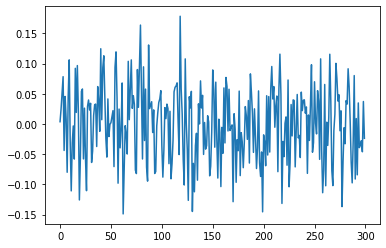

In [293]:
plt.plot(np.mean(vectors, axis=0))

In [175]:
gensim_language_model.most_similar('simple')

[('straightforward', 0.7460168600082397),
 ('Simple', 0.7108174562454224),
 ('uncomplicated', 0.6297484636306763),
 ('simplest', 0.6171398162841797),
 ('easy', 0.5990299582481384),
 ('fairly_straightforward', 0.5893307328224182),
 ('deceptively_simple', 0.5743066072463989),
 ('simpler', 0.5537199974060059),
 ('simplistic', 0.5516539216041565),
 ('disarmingly_simple', 0.5365327000617981)]

3.1027511672884067

In [290]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('../../Desktop/Models/GoogleNews-vectors-negative300.bin',
                                          binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
# see the shape of the vector (300,)
print(vector.shape)
# Processing sentences is not as simple as with Spacy:
vectors = [model[x] for x in "This is some text I am processing with Spacy".split(' ')]


/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(300,)
[array([-0.2890625 ,  0.19921875,  0.16015625,  0.02526855, -0.23632812,
        0.10205078,  0.06640625, -0.16503906,  0.12597656,  0.22070312,
        0.05517578, -0.28710938, -0.02148438,  0.05541992,  0.01574707,
        0.29296875,  0.19433594, -0.01531982,  0.03955078, -0.21484375,
        0.00994873,  0.16015625,  0.07958984, -0.05932617,  0.12353516,
       -0.27148438, -0.10205078,  0.078125  , -0.07519531,  0.22363281,
        0.16210938, -0.04614258,  0.12304688,  0.07275391,  0.25      ,
        0.0072937 , -0.38867188,  0.10644531,  0.20996094,  0.06103516,
        0.10107422,  0.16894531, -0.15429688, -0.08251953,  0.06542969,
       -0.12255859, -0.11621094,  0.04248047,  0.08251953,  0.09716797,
       -0.05371094,  0.125     ,  0.15039062, -0.09228516,  0.23925781,
        0.15234375,  0.1796875 , -0.26171875,  0.15429688,  0.09619141,
       -0.30859375, -0.05224609, -0.18652344, -0.24414062, -0.0612793 ,
       -0.12695312,  0.14160156, -0.03295898,  0.0375976

In [137]:
room_df['most_similar_screened_comment'] = room_df.apply(lambda x: 
    x.comments_screened[:x.minimum_length][np.argmax(x.test_similarity[:x.minimum_length])], axis=1)

TypeError: ("'float' object is not subscriptable", 'occurred at index 0')

In [ ]:
len(clean_scored_room_db.comments_screenediloc[2])

In [88]:
qqq = np.array(lengths)[~np.array(lengths_equal)]

In [89]:
for q in qqq:
    print(q)

[84 85]
[46 45]
[98 97]
[185 184]
[191 192]
[75 76]
[170 169]
[198 199]
[180 179]
[98 97]
[230 232]
[74 75]
[50 48]
[70 69]
[129 130]
[19 20]
[106 107]
[94 95]
[202 200]
[81 80]
[94 93]
[39 38]
[87 88]
[103 104]
[151 150]
[47 48]
[84 83]
[115 116]
[283 284]
[24 23]
[93 94]
[107 106]
[104 103]
[127 128]
[37 38]
[210 208]
[266 267]
[184 185]
[85 84]
[126 128]
[96 97]
[75 76]
[27 28]
[29 30]
[118 119]
[204 203]
[75 76]
[88 89]
[72 73]
[103 100]
[6 7]
[155 154]
[9 8]
[35 36]
[85 86]
[71 72]
[177 178]
[143 144]
[82 83]
[116 118]
[41 42]
[117 116]
[33 34]
[53 55]
[191 190]
[74 75]
[128 129]
[97 96]
[25 26]
[80 79]
[149 150]
[8 9]
[70 71]
[84 86]
[99 98]
[121 122]
[49 50]
[113 114]
[93 92]
[99 98]
[65 66]
[180 181]
[2 3]
[6 7]
[44 45]
[52 51]
[70 71]
[51 50]
[16 15]
[127 126]
[14 13]
[123 125]
[59 61]
[86 85]
[188 187]
[15 16]
[43 44]
[81 82]
[79 78]
[121 120]
[50 51]
[109 106]
[112 113]
[144 145]
[245 246]
[41 40]
[143 142]
[142 141]
[117 118]
[65 63]
[284 283]
[26 25]
[22 23]
[16 15]
[102 1

In [1145]:
print([len(i) for i in tvs])

[10, 10, 10, 10, 10, 10, 10]


In [1148]:

sk.metrics.pairwise.cosine_similarity(np.array(tvs[3]).reshape(1, -1), tvs)

array([[0.05279525, 0.12404034, 0.9552136 , 1.0000001 , 0.26036137,
        0.32052308, 0.15050846, 0.35352445]], dtype=float32)

In [948]:


# Define a database name 
# Set your postgres username
dbname = 'clean_scored_room_db'
username = 'bennett' # change this to your username

In [949]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://bennett@localhost/clean_scored_room_db


In [950]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [944]:
pwd

'/Users/bennett/Documents/GitHub'

In [672]:
type(clean_scored_room_db.room_price[0])

numpy.float64

In [673]:
clean_scored_room_db.dropna(subset = ['room_id', 'mean_topic_score', 'topic_scores']).columns

Index(['room_id', 'host_name', 'user_id', 'user_name', 'comments',
       'topic_scores', 'topic_scores_unnormalized', 'mean_topic_score',
       'mean_topic_score_unnormalized', 'comments_screened',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=114)

In [669]:
def print_types(df):
    """
    Input: a pandas dataframe
    Output: a dictionary whose keys are the column names of that data frame,
    and whose values are a sorted list of types of data the associated column
    """
    
    colnames = list(df.columns)
    type_dict = {}
    for c in colnames:
        initial_list = sorted(list(np.unique(df[c].apply(lambda x: str(type(x))))))
        clean_list = []
        for i in initial_list:
            clean_list.append(i.split("<class '")[1].split("'>")[0])
        type_dict[c] = clean_list
    return type_dict
print_types(clean_scored_room_db)

{'room_id': ['int'],
 'host_name': ['float', 'str'],
 'user_id': ['list'],
 'user_name': ['list'],
 'comments': ['list'],
 'topic_scores': ['numpy.ndarray'],
 'topic_scores_unnormalized': ['numpy.ndarray'],
 'mean_topic_score': ['numpy.ndarray'],
 'mean_topic_score_unnormalized': ['numpy.ndarray'],
 'comments_screened': ['list'],
 'listing_url': ['str'],
 'scrape_id': ['int'],
 'last_scraped': ['str'],
 'name': ['float', 'str'],
 'summary': ['float', 'str'],
 'space': ['float', 'str'],
 'description': ['float', 'str'],
 'experiences_offered': ['str'],
 'neighborhood_overview': ['float', 'str'],
 'notes': ['float', 'str'],
 'transit': ['float', 'str'],
 'access': ['float', 'str'],
 'interaction': ['float', 'str'],
 'house_rules': ['float', 'str'],
 'thumbnail_url': ['float'],
 'medium_url': ['float'],
 'picture_url': ['str'],
 'xl_picture_url': ['float'],
 'host_id': ['int'],
 'host_url': ['str'],
 'host_since': ['float', 'str'],
 'host_location': ['float', 'str'],
 'host_about': ['floa

../../Desktop/Insight Project/airbnb/pickles/clean_scored_room_db.pkl


In [960]:
test = pd.DataFrame({'a':[1, 2, 3], 'b':[4,5,6]})

In [964]:
test.drop(columns=['a'])

,b
0,4
1,5
2,6


In [969]:
# store models as pickles
lda_model_lol = [['LDA 4 topic <.5 >1000', lda04, topics04, corpus04, dictionary04],
                ['LDA 7 topic <.5 >1000', lda07, topics07, corpus07, dictionary07],
                ['LDA 10 topic <.5 >1000', lda10, topics10, corpus10, dictionary10],
                ['LDA 4 topic <.5 >1000 tfidf', lda04_tfidf, topics04_tfidf, corpus04_tfidf, dictionary04_tfidf],
                 ['LDA 7 topic <.5 >1000 tfidf', lda07_tfidf, topics07_tfidf, corpus07_tfidf, dictionary07_tfidf],
                 ['LDA 10 topic <.5 >1000 tfidf', lda10_tfidf, topics10_tfidf, corpus10_tfidf, dictionary10_tfidf],
                 ['LDA 4 topic <1 >0', lda04_permissive, topics04_permissive, 
                  corpus04_permissive, dictionary04_permissive],
                 ['LDA 7 topic <1 >0', lda07_permissive, topics07_permissive, 
                  corpus07_permissive, dictionary07_permissive],
                 ['LDA 10 topic <1 >0', lda10_permissive, topics10_permissive, 
                  corpus10_permissive, dictionary10_permissive],
                 ['LDA 4 topic <1 >0 tfidf', lda04_permissive_tfidf, topics04_permissive_tfidf, 
                  corpus04_permissive_tfidf, dictionary04_permissive_tfidf],
                 ['LDA 7 topic <1 >0 tfidf', lda07_permissive_tfidf, topics07_permissive_tfidf, 
                  corpus07_permissive_tfidf, dictionary07_permissive_tfidf],
                 ['LDA 10 topic <1 >0 tfidf', lda10_permissive_tfidf, topics10_permissive_tfidf, 
                  corpus10_permissive_tfidf, dictionary10_permissive_tfidf],
                ['LDA 10 topic <.05 <0', lda10_strict_top_05, topics10_strict_top_05,
                 corpus10_strict_top_05, dictionary10_strict_top_05],
                ['LDA 10 topic <.05 >200', lda10_st_05_sb0200, topics10_st_05_sb0200, 
                 corpus10_st_05_sb0200, dictionary10_st_05_sb0200],
                ['LDA 7 topic <.05 >1000', lda07_st_05_sb1000, topics07_st_05_sb1000, corpus07_st_05_sb1000, 
                 dictionary07_st_05_sb1000],
                ['LDA 10 topic <.05 >1000',
                 lda10_st_05_sb1000, topics10_st_05_sb1000, corpus10_st_05_sb1000, dictionary10_st_05_sb1000]]
lda_model_dict = {}
for lm in lda_model_lol:
    this_model_dict = {'model': lm[1],
                       'topics': lm[2],
                       'corpus': lm[3],
                       'dictionary': lm[4]}
    lda_model_dict[lm[0]] = this_model_dict

pickle_name = datadir + 'lda_model_dict.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(lda_model_dict, pickle_file)

../../Desktop/Insight Project/airbnb/pickles/lda_model_dict.pkl


In [93]:
with open('../../Desktop/Insight Project/airbnb/pickles/lda_model_dict.pkl', 'rb') as fp:
    lmd_pkl = pickle.load(fp)

In [94]:
lmd_pkl.keys()

dict_keys(['LDA 4 topic <.5 >1000', 'LDA 7 topic <.5 >1000', 'LDA 10 topic <.5 >1000', 'LDA 4 topic <.5 >1000 tfidf', 'LDA 7 topic <.5 >1000 tfidf', 'LDA 10 topic <.5 >1000 tfidf', 'LDA 4 topic <1 >0', 'LDA 7 topic <1 >0', 'LDA 10 topic <1 >0', 'LDA 4 topic <1 >0 tfidf', 'LDA 7 topic <1 >0 tfidf', 'LDA 10 topic <1 >0 tfidf', 'LDA 10 topic <.05 <0', 'LDA 10 topic <.05 >200', 'LDA 7 topic <.05 >1000', 'LDA 10 topic <.05 >1000'])

In [96]:
lda_10_less05_great1000 = lmd_pkl['LDA 10 topic <.05 >1000']


dict_keys(['model', 'topics', 'corpus', 'dictionary'])

In [1114]:
lda_10_less05_great1000 = lmd_pkl['LDA 10 topic <.05 >1000']
pickle_name = '../Flask/Airbnb/MVP/lda_10_less05_great1000.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(lda_10_less05_great1000, pickle_file)

../Flask/Airbnb/MVP/lda_10_less05_great1000.pkl


In [1120]:
lda_10_less05_great1000.keys()

dict_keys(['model', 'topics', 'corpus', 'dictionary'])

In [1117]:
with open('../Flask/Airbnb/MVP/lda_10_less05_great1000.pkl', 'rb') as fp:
    good_lmd_pkl = pickle.load(fp)

In [970]:
clean_scored_room_db.topic_scores

0        [[0.3251676503712088, 0.0, 0.0, 0.0, 0.9456563...
1        [[0.0, 0.0, 0.0, 0.18682568814255882, 0.0, 0.0...
3        [[0.0, 0.03309587654277409, 0.1352477273350135...
4        [[0.10514095077870025, 0.0, 0.0, 0.0, 0.453662...
5        [[0.08771791168921587, 0.08770793314506449, 0....
                               ...                        
19369    [[0.4266309674972206, 0.026658812829471436, 0....
19375    [[0.017357211613313755, 0.017359088219601054, ...
19382    [[0.08770580137777596, 0.964763821690127, 0.08...
19406    [[0.032111729127302216, 0.03211075305272693, 0...
19483    [[0.49502416266692345, 0.4693936440073529, 0.0...
Name: topic_scores, Length: 14447, dtype: object

In [1001]:
clean_scored_room_db_verbose.topic_scores.apply(lambda x: x.tolist())


0        [[0.3251676503712088, 0.0, 0.0, 0.0, 0.9456563...
1        [[0.0, 0.0, 0.0, 0.18682568814255882, 0.0, 0.0...
3        [[0.0, 0.03309587654277409, 0.1352477273350135...
4        [[0.10514095077870025, 0.0, 0.0, 0.0, 0.453662...
5        [[0.08771791168921587, 0.08770793314506449, 0....
                               ...                        
19369    [[0.4266309674972206, 0.026658812829471436, 0....
19375    [[0.017357211613313755, 0.017359088219601054, ...
19382    [[0.08770580137777596, 0.964763821690127, 0.08...
19406    [[0.032111729127302216, 0.03211075305272693, 0...
19483    [[0.49502416266692345, 0.4693936440073529, 0.0...
Name: topic_scores, Length: 14447, dtype: object

In [1005]:
topic_scores_list[0]

[[0.3251676503712088,
  0.0,
  0.0,
  0.0,
  0.9456563853493865,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.08772178026996966,
  0.0877213947106921,
  0.08771077549330172,
  0.08771683988329451,
  0.08771674185974937,
  0.08771967603120061,
  0.08771610797415745,
  0.08771007625867971,
  0.0877106970744656,
  0.9647554686122777],
 [0.047142429866475696,
  0.04714242459789887,
  0.04714256684947312,
  0.04715065938347486,
  0.047144937709043946,
  0.04714623904751948,
  0.04714319381011518,
  0.0471442264511727,
  0.9899465340647106,
  0.0471695314256586],
 [0.03321104530059488,
  0.03321071128122115,
  0.033218573107591645,
  0.033222117424279524,
  0.0332141720930656,
  0.033210865919820094,
  0.03321058138479804,
  0.7937038131432005,
  0.033210698910133236,
  0.6010067498470678],
 [0.0,
  0.678707300509623,
  0.40417999610103905,
  0.0,
  0.0,
  0.0,
  0.0,
  0.13709322321391104,
  0.46051075940769454,
  0.38095960363964265],
 [0.017239292484681798,
  0.01723911622641312,
  0.017237843

In [1003]:
topic_scores_list.apply(lambda x: [sublist[0] for sublist in x])

0        [0.3251676503712088, 0.08772178026996966, 0.04...
1        [0.0, 0.11806735467970288, 0.03714155754214682...
3        [0.0, 0.55252683881945, 0.08770995986846947, 0...
4        [0.10514095077870025, 0.0, 0.42832337488672806...
5        [0.08771791168921587, 0.08772797756054346, 0.3...
                               ...                        
19369            [0.4266309674972206, 0.03102334852557586]
19375                               [0.017357211613313755]
19382                                [0.08770580137777596]
19406                               [0.032111729127302216]
19483                                [0.49502416266692345]
Name: topic_scores, Length: 14447, dtype: object

In [986]:
clean_scored_room_db_verbose.shape

(14447, 95)

In [1025]:
cols2change2list = ['topic_scores', 'topic_scores_unnormalized', 
                   'mean_topic_score', 'mean_topic_score_unnormalized']

In [1027]:
type(clean_scored_room_db_verbose.topic_scores.iloc[0][0])

numpy.ndarray

In [1028]:
clean_scored_room_db_verbose.shape

(14447, 95)

In [1034]:
clean_scored_room_db_verbose.topic_scores.apply(lambda x: x.tolist())[:][6]

[[0.02740998195899897,
  0.5683296714406859,
  0.5553295015755887,
  0.027408066764335583,
  0.02740482594053019,
  0.027410966354763453,
  0.027414793170965852,
  0.027407536155366344,
  0.6027867675945254,
  0.027404440043098013],
 [0.0,
  0.23397236650523404,
  0.0,
  0.0,
  0.5930373995601812,
  0.625757199043215,
  0.0,
  0.0,
  0.44943464739651373,
  0.0],
 [0.047157570151616805,
  0.047150657753573876,
  0.047146806409847204,
  0.04714269690491314,
  0.047143160541367246,
  0.04715189587365016,
  0.9899462724933495,
  0.04714288130577557,
  0.047143824384471976,
  0.04715221198941432],
 [0.01871662492939664,
  0.46118763850408756,
  0.018710547889070457,
  0.018713529262753416,
  0.018709609850506348,
  0.01870954852257645,
  0.018710274701019096,
  0.01870806410790962,
  0.8857229407694622,
  0.01871039038779595],
 [0.03160696019567288,
  0.360778433978441,
  0.031593734437399414,
  0.031599439943371097,
  0.031598797367822305,
  0.666128837774682,
  0.03159400982692032,
  0.03

In [985]:
clean_scored_room_db_verbose = deepcopy(clean_scored_room_db)

for i in range(10):
    col_name_norm = 'topic_score_normalized_' + str(i)
    col_name_unnorm = 'topic_score_unnormalized_' + str(i)
    
    topic_scores_norm_aslist = \
        clean_scored_room_db_verbose.topic_scores.apply(lambda x: x.tolist())
    topic_scores_unnorm_aslist = \
        clean_scored_room_db_verbose.topic_scores_unnormalized.apply(lambda x: x.tolist())
    
    clean_scored_room_db_verbose[col_name_norm] = \
        np.vstack(clean_scored_room_db_verbose.topic_scores)[:, i]
    clean_scored_room_db_verbose[col_name_unnorm] = \
        np.vstack(clean_scored_room_db_verbose.topic_scores_unnormalized)[:, i]
    
clean_scored_room_db_verbose = \
    clean_scored_room_db_verbose.drop(columns=['topic_scores', 'topic_scores_unnormalized'])

pickle_name = datadir + 'clean_scored_room_db_verbose.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db_verbose, pickle_file)

clean_scored_room_db_verbose.to_sql('clean_scored_room_db', engine, if_exists='replace')

ValueError: Length of values does not match length of index

AttributeError: 'list' object has no attribute 'replace'

In [3]:
clean_scored_room_db = \
    pd.read_json('/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.json', orient='columns')

In [27]:
clean_scored_room_db.topic_scores

0        [[0.3251676504, 0.0, 0.0, 0.0, 0.9456563853000...
1        [[0.0, 0.0, 0.0, 0.1868256881, 0.0, 0.0, 0.0, ...
3        [[0.0, 0.0330958765, 0.1352477273, 0.093013469...
4        [[0.10514095080000001, 0.0, 0.0, 0.0, 0.453662...
5        [[0.0877179117, 0.08770793310000001, 0.0877090...
                               ...                        
19369    [[0.4266309675, 0.0266588128, 0.0266657364, 0....
19375    [[0.017357211600000002, 0.0173590882, 0.787024...
19382    [[0.0877058014, 0.9647638217000001, 0.08770580...
19406    [[0.0321117291, 0.0321107531, 0.0321113392, 0....
19483    [[0.4950241627, 0.46939364400000005, 0.0204071...
Name: topic_scores, Length: 14447, dtype: object

In [9]:
room_types = np.unique(clean_scored_room_db.room_type.dropna())
room_types_allowed = room_types[np.array([True, False, True])]
np.unique(clean_scored_room_db[clean_scored_room_db.room_type.isin(room_types_allowed)].room_type)

array(['Entire home/apt', 'Shared room'], dtype=object)

In [12]:
clean_scored_room_db.accommodates

0        3.0
1        2.0
3        5.0
4        1.0
5        2.0
        ... 
19369    2.0
19375    NaN
19382    NaN
19406    NaN
19483    6.0
Name: accommodates, Length: 14447, dtype: float64

In [25]:
clean_scored_room_db.listing_url.iloc[0], clean_scored_room_db.room_id.iloc[0], clean_scored_room_db.host_id.iloc[0], 


('https://www.airbnb.com/rooms/17938814', 2515, 55199493.0)

In [21]:
clean_scored_room_db.columns

Index(['room_id', 'host_name', 'user_id', 'comments', 'topic_scores',
       'topic_scores_unnormalized', 'mean_topic_score',
       'mean_topic_score_unnormalized', 'access', 'accommodates', 'amenities',
       'availability_30', 'availability_365', 'availability_60',
       'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'calendar_last_scraped',
       'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee',
       'coordinates', 'country', 'country_code', 'date_last_review',
       'description', 'experiences_offered', 'extra_people', 'features',
       'first_review', 'guests_included', 'has_availability', 'host_about',
       'host_acceptance_rate', 'host_id', 'host_listings_count',
       'host_location', 'host_neighbourhood', 'host_picture_url',
       'host_response_rate', 'host_response_time', 'host_since',
       'host_thumbnail_url', 'host_total_listings_count', 'host_url',
       'host_verifications', 'house

In [473]:
clean_scored_room_db.picture_url

0        https://a0.muscache.com/im/pictures/f0813a11-4...
2        https://a0.muscache.com/im/pictures/e49999c2-9...
3        https://a0.muscache.com/im/pictures/feb453bd-f...
4        https://a0.muscache.com/im/pictures/be2fdcf6-e...
5        https://a0.muscache.com/im/pictures/2090980c-b...
                               ...                        
48636    https://a0.muscache.com/im/pictures/18c846b2-3...
48683    https://a0.muscache.com/im/pictures/9d2b7e92-5...
48685    https://a0.muscache.com/im/pictures/504c50db-3...
48694    https://a0.muscache.com/im/pictures/a0bb90cf-e...
48745    https://a0.muscache.com/im/pictures/b41df06f-9...
Name: picture_url, Length: 36686, dtype: object

In [14]:
x = '1'
y = '2'
xy = [x, y]
for i in xy:
    i = float(i)
print(type(x), type(y))

<class 'str'> <class 'str'>


In [1055]:
csrdb_from_json['room_id'].iloc[0]

numpy.int64

In [1071]:
clean_scored_room_db.host_name.values

array(['Mizi', 'Jennifer', 'Cindy', ..., 'Margarita', 'Clara', 'Jerry'],
      dtype=object)

In [1093]:
room_df = pd.read_json('/Users/bennett/Documents/Flask/Airbnb/MVP/clean_scored_room_db.json', orient='columns')

In [29]:
clean_scored_room_db[clean_scored_room_db.room_id == 2515].xl_picture_url

0    https://a0.muscache.com/im/pictures/b510574b-e...
Name: xl_picture_url, dtype: object

In [31]:
b_listings1 = pd.read_csv('../../Downloads/NYC data 0916/listings.csv')
b_listings2 = pd.read_csv('../../Downloads/NYC data 0916/listings 2.csv')

/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
b_listings1.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [37]:
b_listings2.listing_url.iloc[0]

'https://www.airbnb.com/rooms/2595'

In [35]:
for c in sorted(b_listings2.columns):
    print(c)

access
accommodates
amenities
availability_30
availability_365
availability_60
availability_90
bathrooms
bed_type
bedrooms
beds
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
calendar_last_scraped
calendar_updated
cancellation_policy
city
cleaning_fee
country
country_code
description
experiences_offered
extra_people
first_review
guests_included
has_availability
host_about
host_acceptance_rate
host_has_profile_pic
host_id
host_identity_verified
host_is_superhost
host_listings_count
host_location
host_name
host_neighbourhood
host_picture_url
host_response_rate
host_response_time
host_since
host_thumbnail_url
host_total_listings_count
host_url
host_verifications
house_rules
id
instant_bookable
interaction
is_business_travel_ready
is_location_exact
jurisdiction_names
last_review
last_scraped
latitude
license
listing_url
longitude
market
maximum_maximum_nights
maximum_minimum

In [1103]:
user_input = 54321
room_df = room_df.dropna(subset = ['room_id', 'mean_topic_score', 'topic_scores'])
query_results=room_df[room_df.room_id.apply(lambda x: x > float(user_input))]
listings = []
for i in range(0, 10):
    listings.append(dict(listing_id = query_results.iloc[i]['room_id'],
                        mean_topic_score =  query_results.iloc[i]['mean_topic_score']))

In [1104]:
listings

[{'listing_id': 54453,
  'mean_topic_score': [0.4351450553,
   0.0606205924,
   0.1766637875,
   0.0200866123,
   0.3945048504,
   0.23145671480000002,
   0.0527060518,
   0.048502279200000005,
   0.0604842507,
   0.040747115]},
 {'listing_id': 54544,
  'mean_topic_score': [0.1839472795,
   0.1183796891,
   0.13392099500000001,
   0.0558752311,
   0.21314608980000002,
   0.0921960186,
   0.2263809433,
   0.15817994200000002,
   0.165490266,
   0.3675628383]},
 {'listing_id': 54860,
  'mean_topic_score': [0.1289011686,
   0.1425173227,
   0.1347576356,
   0.08011280700000001,
   0.35489794900000005,
   0.18019607810000002,
   0.1686818833,
   0.08843401070000001,
   0.1568832349,
   0.275969309]},
 {'listing_id': 55320,
  'mean_topic_score': [0.1917952674,
   0.1140676795,
   0.288049007,
   0.1447897898,
   0.1499385812,
   0.1562146602,
   0.2124737087,
   0.0967432543,
   0.1478361963,
   0.2824340696]},
 {'listing_id': 55668,
  'mean_topic_score': [0.6541525823000001,
   0.109312836

In [1107]:

with open('../Flask/Airbnb/MVP/model_dict.json', 'w') as fp:
    json.dump(lda_model_dict, fp)

TypeError: Object of type LdaMulticore is not JSON serializable